# Predcition of Hospital Admission Related to Urinary Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to urinary tract infection (uti).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'uti_date_'+str(i), 'uti_ab_date_'+str(i), 'uti_ab_type_'+str(i),
                   'incdt_uti_date_'+str(i), 'admitted_uti_date_'+str(i), 'sgss_gp_cov_uti_date_'+str(i)]]
    
    #drop rows with no uti reord
    datum = datum[datum['uti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with uti_i
    datum = datum[datum['sgss_gp_cov_uti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'uti_date_'+str(i): 'uti_date', 'uti_ab_date_'+str(i): 'uti_ab_date', 
                           'uti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_uti_date_'+str(i): 'incdt_uti_date', 'incdt_uti_type_'+str(i): 'incdt_uti_type',
                           'admitted_uti_date_'+str(i): 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_'+str(i): 'sgss_gp_cov_uti_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [8]:
#build cox models
def cox_model_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [9]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [10]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [13]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_train[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_test[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_train, data_test

In [14]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [18]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_antibacterial_brit_cat_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [19]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_uti.csv.gz')

In [20]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [21]:
#process 20 utis and concatenate them 
data_uti_1 = proc_infec_data(data,1)
data_uti_2 = proc_infec_data(data,2)
data_uti_3 = proc_infec_data(data,3)
data_uti_4 = proc_infec_data(data,4)
data_uti_5 = proc_infec_data(data,5)
data_uti_6 = proc_infec_data(data,6)
data_uti_7 = proc_infec_data(data,7)
data_uti_8 = proc_infec_data(data,8)
data_uti_9 = proc_infec_data(data,9)
data_uti_10 = proc_infec_data(data,10)
data_uti_11 = proc_infec_data(data,11)
data_uti_12 = proc_infec_data(data,12)
data_uti_13 = proc_infec_data(data,13)
data_uti_14 = proc_infec_data(data,14)
data_uti_15 = proc_infec_data(data,15)
data_uti_16 = proc_infec_data(data,16)
data_uti_17 = proc_infec_data(data,17)
data_uti_18 = proc_infec_data(data,18)
data_uti_19 = proc_infec_data(data,19)
data_uti_20 = proc_infec_data(data,20)

data_uti = pd.concat([data_uti_1, data_uti_2, data_uti_3, data_uti_4, data_uti_5, data_uti_6, data_uti_7, data_uti_8, data_uti_9, data_uti_10, data_uti_11, data_uti_12, data_uti_13, data_uti_14, data_uti_15, data_uti_16, data_uti_17, data_uti_18, data_uti_19, data_uti_20])
data_uti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [22]:
##add variable season
#convert data types
data_uti['uti_date'] = data_uti['uti_date'].astype('datetime64[ns]')
data_uti['admitted_uti_date'] = data_uti['admitted_uti_date'].astype('datetime64[ns]')
data_uti.died_date = data_uti.died_date.astype('datetime64[ns]')
data_uti.deregistered_date = data_uti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_uti['date'] = data_uti['uti_date'] 
data_uti['date'] = data_uti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_uti with today's date in year and month
data_uti = data_uti[data_uti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_uti = data_uti[data_uti['date'] != last_1_month_date_y_m]
data_uti = data_uti[data_uti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of uti records
data_uti['season'] = np.nan
data_uti['date_month'] = pd.DatetimeIndex(data_uti['date']).month

conditions = [
    (data_uti['date_month'] >= 3) & (data_uti['date_month'] <= 5),
    (data_uti['date_month'] >= 6) & (data_uti['date_month'] <= 8),
    (data_uti['date_month'] >= 9) & (data_uti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_uti['season'] = np.select(conditions, choices, default='winter')

In [23]:
#add variable time period
data_uti.loc[(data_uti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_uti.loc[((data_uti['date'] >= '2020-01') & (data_uti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_uti.loc[(data_uti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [24]:
#scenario 1
#not hosped (nothing happened)
data_uti.loc[data_uti['admitted_uti_date'].isnull(), 'event_uti_admitted'] = 0

In [25]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['uti_date']).dt.days
data_uti.loc[((data_uti['delta_uti_admitted'] >= 0) & (data_uti['delta_uti_admitted'] <= 30)), 'event_uti_admitted'] = 1

#scenario 2
#drop whoever was admitted before uti consultation, i.e. negative value for delta_uti_admitted
data_uti = data_uti[~(data_uti['delta_uti_admitted'] < 0)]

In [26]:
#scenario 3
#censor died patients
data_uti['delta_admitted_died'] = (data_uti['died_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_uti.loc[((data_uti['delta_admitted_died'] >= 0) & (data_uti['delta_admitted_died'] <= 30)), 'event_uti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_uti['delta_admitted_deregistered'] = (data_uti['deregistered_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_uti.loc[((data_uti['delta_admitted_deregistered'] > 0) & (data_uti['delta_admitted_deregistered'] <= 30)), 'event_uti_admitted'] = 0

#agg scenario 3s
data_uti['delta_admitted_died_deregistered'] = data_uti['delta_admitted_deregistered'].combine_first(data_uti['delta_admitted_died'])
data_uti.loc[data_uti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [27]:
#scenario 1
#any other patients (nothing happened)
data_uti['event_uti_admitted'] = data_uti['event_uti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_uti['duration_uti_admitted'] = data_uti['delta_uti_admitted'].combine_first(data_uti['delta_admitted_died_deregistered'])
data_uti['duration_uti_admitted'] = data_uti['duration_uti_admitted'].replace(np.NaN, 30)
data_uti.loc[(data_uti['duration_uti_admitted'] > 30), 'duration_uti_admitted'] = 30

#give value 1 to event_uti_admitted if duration_uti_admitted is greater or equal to 0 and less than 30
data_uti.loc[((data_uti['duration_uti_admitted'] >= 0) & (data_uti['duration_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

#drop any rows with value 0 in duration column
data_uti = data_uti[~(data_uti['duration_uti_admitted'] == 0)]

In [28]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_uti.loc[((data_uti['delta_uti_admitted'] > 0) & (data_uti['delta_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [29]:
#drop anybody with age less than 18 or 0!
data_uti = data_uti[~(data_uti['age'] < 18)] 
data_uti['age'][data_uti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_uti = data_uti[data_uti['age_cat'] != '0-4']
data_uti = data_uti[data_uti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_uti['bmi'][data_uti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_uti['bmi'] = data_uti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_uti['antibacterial_brit'][data_uti['antibacterial_brit'] < 0] = np.nan

In [30]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"smoking_status": dict_smoking})

In [31]:
#drop rows with missing region
if ('region' in data_uti.columns) and (data_uti['region'].isnull().sum() > 0):
   data_uti = data_uti[data_uti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_uti.columns) and (data_uti['antibacterial_brit'].isnull().sum() > 0):
    data_uti['antibacterial_brit'] = data_uti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_uti.columns) and (data_uti['ethnicity'].isnull().sum() > 0):
    data_uti['ethnicity'] = data_uti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_uti.columns) and (data_uti['smoking_status'].isnull().sum() > 0):
    data_uti['smoking_status'] = data_uti['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_uti.columns) and (data_uti['imd'].isnull().sum() > 0):
    data_uti['imd'] = data_uti['imd'].fillna(0)

In [32]:
#missing values of bmi assign 5 and 0; categorise bmi
data_uti['bmi_cat'] = 5

for idx, x in enumerate(data_uti['bmi_cat']):
    if data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 30:
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 25) and (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 30):
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 18.5) and (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 25):
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 18.5:
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_uti.columns) and (data_uti['bmi_cat'].isnull().sum() > 0):
    data_uti['bmi_cat'] = data_uti['bmi_cat'].fillna(0)

In [33]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_uti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_uti['ab_type_cat'] = np.where(data_uti['ab_type'].isin(ab_series[mask].index),'other',data_uti['ab_type'])
#assign no to non ab users
data_uti.loc[data_uti['uti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_uti['ab_type_cat'] = data_uti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [34]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"ethnicity": dict_ethnicity})
data_uti = data_uti.replace({"smoking_status": dict_smoking})
data_uti = data_uti.replace({"imd": dict_imd})
data_uti = data_uti.replace({"bmi_cat": dict_bmi})
data_uti = data_uti.replace({"flu_vaccine": dict_flu})
data_uti = data_uti.replace({"region": dict_region})
data_uti = data_uti.replace({"age_cat": dict_age})
data_uti = data_uti.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [35]:
#categorise CCI
data_uti['CCI_cat'] = pd.cut(data_uti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_uti['antibacterial_brit'].clip(0, data_uti['antibacterial_brit'].quantile(0.95), inplace=True)
#add a categorical variable for combination of antibiotics prescribed and antibiotic history
data_uti.loc[((data_uti['uti_ab_date'].notnull() == True) & (data_uti['antibacterial_brit'] == 0)), 'antibacterial_brit_cat'] = 'yes_none0'
data_uti.loc[((data_uti['uti_ab_date'].notnull() == True) & (data_uti['antibacterial_brit'] == 1)), 'antibacterial_brit_cat'] = 'yes_low1'
data_uti.loc[((data_uti['uti_ab_date'].notnull() == True) & (data_uti['antibacterial_brit'] >= 2) & (data_uti['antibacterial_brit'] <= 4)), 'antibacterial_brit_cat'] = 'yes_medium2_4'
data_uti.loc[((data_uti['uti_ab_date'].notnull() == True) & (data_uti['antibacterial_brit'] >= 5)), 'antibacterial_brit_cat'] = 'yes_high5_more'
data_uti.loc[(data_uti['uti_ab_date'].notnull() == False), 'antibacterial_brit_cat'] = 'no_any'
data_uti['antibacterial_brit_cat'].value_counts()

no_any           160088
yes_none0          9178
yes_medium2_4      7389
yes_low1           1245
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

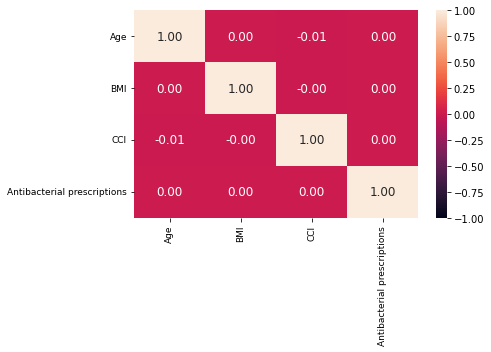

In [36]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_uti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_uti/corr_uti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [37]:
data_uti = data_uti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'antibacterial_brit_cat', 'uti_ab_date', 'ab_type_cat', 'incdt_uti_date', 'date', 'period',
                                   'event_uti_admitted', 'duration_uti_admitted'
                                    ]]

In [38]:
#incident and prevalent infection 
data_uti_incdt = data_uti[data_uti['incdt_uti_date'] == 0]
data_uti_prevl = data_uti[data_uti['incdt_uti_date'] == 1]
#switch variable uti_ab_date into a binary variable
data_uti_incdt[['uti_ab_date']] = data_uti_incdt[['uti_ab_date']].where(data_uti_incdt[['uti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_uti_prevl[['uti_ab_date']] = data_uti_prevl[['uti_ab_date']].where(data_uti_prevl[['uti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_uti_incdt_males = data_uti_incdt[data_uti_incdt['sex'] == 'male']
data_uti_incdt_females = data_uti_incdt[data_uti_incdt['sex'] == 'female']
data_uti_prevl_males = data_uti_prevl[data_uti_prevl['sex'] == 'male']
data_uti_prevl_females = data_uti_prevl[data_uti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_uti_incdt_15_24 = data_uti_incdt[data_uti_incdt['age_cat'] == '15_24']
data_uti_incdt_25_34 = data_uti_incdt[data_uti_incdt['age_cat'] == '25_34']
data_uti_incdt_35_44 = data_uti_incdt[data_uti_incdt['age_cat'] == '35_44']
data_uti_incdt_45_54 = data_uti_incdt[data_uti_incdt['age_cat'] == '45_54']
data_uti_incdt_55_64 = data_uti_incdt[data_uti_incdt['age_cat'] == '55_64']
data_uti_incdt_65_74 = data_uti_incdt[data_uti_incdt['age_cat'] == '65_74']
data_uti_incdt_75_more = data_uti_incdt[data_uti_incdt['age_cat'] == '75_more']
data_uti_prevl_15_24 = data_uti_prevl[data_uti_prevl['age_cat'] == '15_24']
data_uti_prevl_25_34 = data_uti_prevl[data_uti_prevl['age_cat'] == '25_34']
data_uti_prevl_35_44 = data_uti_prevl[data_uti_prevl['age_cat'] == '35_44']
data_uti_prevl_45_54 = data_uti_prevl[data_uti_prevl['age_cat'] == '45_54']
data_uti_prevl_55_64 = data_uti_prevl[data_uti_prevl['age_cat'] == '55_64']
data_uti_prevl_65_74 = data_uti_prevl[data_uti_prevl['age_cat'] == '65_74']
data_uti_prevl_75_more = data_uti_prevl[data_uti_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_uti_incdt_prepandemic = data_uti_incdt[data_uti_incdt['date'] <= '2019-12']
data_uti_incdt_during_pandemic = data_uti_incdt[(data_uti_incdt['date'] >= '2020-03') & (data_uti_incdt['date']<= '2021-03')]
data_uti_incdt_post_2nd_lockdown = data_uti_incdt[data_uti_incdt['date'] <= '2021-04']
data_uti_prevl_prepandemic = data_uti_prevl[data_uti_prevl['date'] <= '2019-12']
data_uti_prevl_during_pandemic = data_uti_prevl[(data_uti_prevl['date'] >= '2020-03') & (data_uti_prevl['date']<= '2021-03')]
data_uti_prevl_post_2nd_lockdown = data_uti_prevl[data_uti_prevl['date'] <= '2021-04']

#incident and prevalent infection stratified by antibiotics history categories
data_uti_incdt_none0 = data_uti_incdt[data_uti_incdt['antibacterial_brit_cat'] == 'none0']
data_uti_incdt_low1 = data_uti_incdt[data_uti_incdt['antibacterial_brit_cat'] == 'low1']
data_uti_incdt_medium2_4 = data_uti_incdt[data_uti_incdt['antibacterial_brit_cat'] == 'medium2_4']
data_uti_incdt_high5_more = data_uti_incdt[data_uti_incdt['antibacterial_brit_cat'] == 'high5_more']
data_uti_prevl_none0 = data_uti_prevl[data_uti_prevl['antibacterial_brit_cat'] == 'none0']
data_uti_prevl_low1 = data_uti_prevl[data_uti_prevl['antibacterial_brit_cat'] == 'low1']
data_uti_prevl_medium2_4 = data_uti_prevl[data_uti_prevl['antibacterial_brit_cat'] == 'medium2_4']
data_uti_prevl_high5_more = data_uti_prevl[data_uti_prevl['antibacterial_brit_cat'] == 'high5_more']

# no antibiotics and incident hospital admission
data_uti_no_abs_incdt = data_uti[data_uti['uti_ab_date'].isnull()]
data_uti_no_abs_incdt = data_uti_no_abs_incdt[data_uti_no_abs_incdt['incdt_uti_date'] == 0]

# with antibiotics and incident hospital admission
data_uti_abs_incdt = data_uti[data_uti['uti_ab_date'].notnull()]
data_uti_abs_incdt = data_uti_abs_incdt[data_uti_abs_incdt['incdt_uti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_uti_no_abs_prevl = data_uti[data_uti['uti_ab_date'].isnull()]
data_uti_no_abs_prevl = data_uti_no_abs_prevl[data_uti_no_abs_prevl['incdt_uti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_uti_abs_prevl = data_uti[data_uti['uti_ab_date'].notnull()]
data_uti_abs_prevl = data_uti_abs_prevl[data_uti_abs_prevl['incdt_uti_date'] == 1]

In [39]:
#store data for plotting hosp admission counts and percentages
%store data_uti
# save data
data_uti.to_csv('../output/hospitalisation_prediction_uti/data_uti.csv')

Stored 'data_uti' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident uti with no antibiotics

<lifelines.CoxPHFitter: fitted with 108066 total observations, 107364 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 108066
number of events observed = 702
   partial log-likelihood = -8110.93
         time fit was run = 2023-06-28 10:49:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.02       0.11            -0.20             0.24                 0.82                 1.27
CCI_cat[T.medium]               -0.03       0.97       0.13            -0.28             0.22                 0.76                 1.25
CCI_cat[T.high]                  0.18       1.20       0.14            -0.10             0.46                 0.91                 1.59
CCI_cat[T.very_high]             0.14       1.16       0.13            -0.11             0.40                 0.90                 1.49
age_cat[T.25_34]                -0.11       0.89       0.14            -0.39             0.16                 0.68                 1.18
age_cat[T.35_44]                -0.24       0.79       0.14            -0.52             0.04                 0.59                 1.04
age_cat[T.45_54]                 0.04       1.04       0.13            -0.22             0.30                 0.80                 1.36
age_cat[T.55_64]                -0.18       0.84       0.14            -0.46             0.10                 0.63                 1.10
age_cat[T.65_74]                -0.12       0.89       0.14            -0.39             0.16                 0.67                 1.17
age_cat[T.75_more]               0.00       1.00       0.14            -0.27             0.27                 0.77                 1.31
antibacterial_brit              -0.07       0.93       0.03            -0.12            -0.02                 0.88                 0.98
bmi_cat[T.obese]                 0.16       1.17       0.15            -0.13             0.44                 0.88                 1.56
bmi_cat[T.overweight]            0.00       1.00       0.18            -0.35             0.36                 0.70                 1.43
bmi_cat[T.underweight]           0.28       1.33       0.24            -0.18             0.75                 0.83                 2.11
bmi_cat[T.unknown]              -0.01       0.99       0.16            -0.32             0.30                 0.73                 1.35
ethnicity[T.unknown]            -0.05       0.96       0.12            -0.29             0.19                 0.75                 1.21
ethnicity[T.white]              -0.05       0.96       0.11            -0.26             0.17                 0.77                 1.18
flu_vaccine[T.yes]              -0.13       0.88       0.13            -0.39             0.13                 0.68                 1.13
imd[T.medium]                    0.08       1.09       0.12            -0.15             0.32                 0.86                 1.37
imd[T.unaffluent]               -0.12       0.88       0.12            -0.37             0.12                 0.69                 1.13
imd[T.unknown]                   0.24       1.27       0.17            -0.10             0.58                 0.90                 1.78
imd[T.very_affluent]            -0.02       0.98       0.12            -0.26             0.21                 0.77                 1.24
imd[T.very_unaffluent]          -0.16       0.85       0.13            -0.41             0.08                 0.66                 1.09
region[T.east_midlands]         -0.08       0.93       0.18            -0.44             0.28                 0.65                 1.32
region[T.london]                 0.15       1.16       0.15        

12773


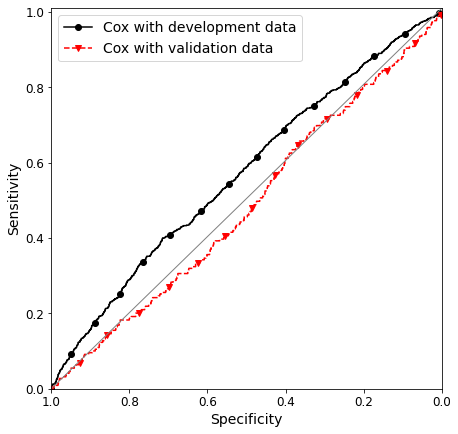

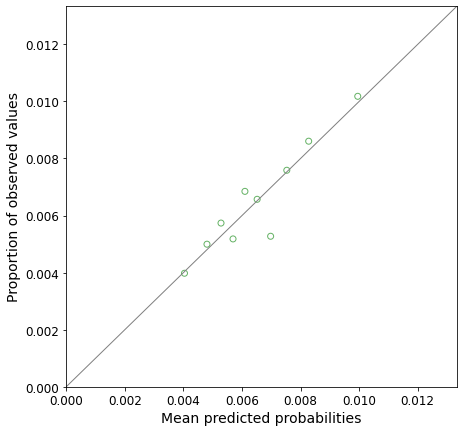

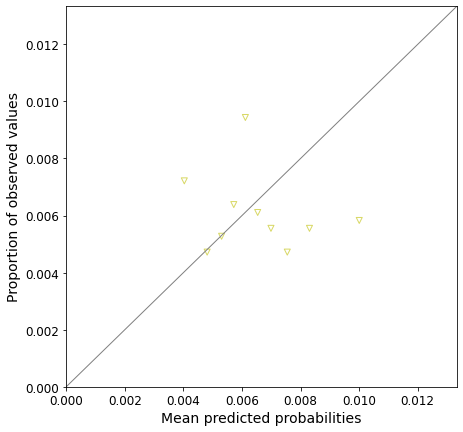

In [40]:
#data prep
data, data_uti_no_abs_incdt_enc = cox_data_prep(data_uti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'no_abs_incdt', data_uti_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'no_abs_incdt', data_uti_no_abs_incdt)

try:
    #build cox model 
    cph_uti_no_abs_incdt, data_uti_no_abs_incdt_train, data_uti_no_abs_incdt_test = cox_model_build('uti', 'no_abs_incdt', data_uti_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_uti_no_abs_incdt, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_no_abs_incdt.csv', data_uti_no_abs_incdt_enc, data_uti_no_abs_incdt, 'sum_betas_cph_uti_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_uti_no_abs_incdt, 'event_uti_admitted', data_uti_no_abs_incdt_train, data_uti_no_abs_incdt_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_uti_no_abs_incdt, data_uti_no_abs_incdt_train, 'event_uti_admitted', data_uti_no_abs_incdt_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_no_abs_incdt_train.jpg', 'calibration_cph_uti_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_uti_no_abs_incdt, 'uti', 'no_abs_incdt', data_uti_no_abs_incdt_train, data_uti_no_abs_incdt_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident uti with antibiotics

<lifelines.CoxPHFitter: fitted with 12015 total observations, 11945 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 12015
number of events observed = 70
   partial log-likelihood = -641.54
         time fit was run = 2023-06-28 10:49:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.17       0.84       0.38            -0.91             0.57                 0.40                 1.76
CCI_cat[T.medium]                0.14       1.15       0.39            -0.63             0.90                 0.53                 2.47
CCI_cat[T.high]                 -0.31       0.74       0.54            -1.37             0.75                 0.26                 2.12
CCI_cat[T.very_high]             0.44       1.55       0.38            -0.31             1.19                 0.73                 3.30
age_cat[T.25_34]                 0.46       1.58       0.43            -0.38             1.30                 0.68                 3.65
age_cat[T.35_44]                 0.38       1.46       0.44            -0.49             1.24                 0.61                 3.47
age_cat[T.45_54]                -0.33       0.72       0.53            -1.37             0.70                 0.25                 2.02
age_cat[T.55_64]                 0.06       1.07       0.47            -0.86             0.99                 0.42                 2.69
age_cat[T.65_74]                 0.08       1.09       0.46            -0.82             0.98                 0.44                 2.68
age_cat[T.75_more]               0.16       1.18       0.46            -0.74             1.06                 0.48                 2.90
antibacterial_brit              -0.03       0.97       0.09            -0.20             0.14                 0.82                 1.15
bmi_cat[T.obese]                 0.32       1.38       0.53            -0.71             1.36                 0.49                 3.90
bmi_cat[T.overweight]            0.86       2.37       0.58            -0.27             2.00                 0.76                 7.38
bmi_cat[T.underweight]          -0.43       0.65       1.12            -2.63             1.76                 0.07                 5.81
bmi_cat[T.unknown]               0.48       1.61       0.55            -0.60             1.56                 0.55                 4.75
ethnicity[T.unknown]             0.25       1.28       0.46            -0.65             1.15                 0.52                 3.15
ethnicity[T.white]               0.56       1.74       0.41            -0.24             1.35                 0.79                 3.86
flu_vaccine[T.yes]              -0.42       0.65       0.46            -1.33             0.49                 0.26                 1.63
imd[T.medium]                   -0.20       0.82       0.36            -0.91             0.51                 0.40                 1.67
imd[T.unaffluent]               -0.28       0.75       0.37            -1.01             0.44                 0.37                 1.56
imd[T.unknown]                  -0.39       0.67       0.63            -1.62             0.83                 0.20                 2.30
imd[T.very_affluent]            -0.57       0.57       0.40            -1.35             0.21                 0.26                 1.24
imd[T.very_unaffluent]          -0.26       0.77       0.37            -0.98             0.47                 0.37                 1.59
region[T.east_midlands]         -1.37       0.25       0.80            -2.94             0.20                 0.05                 1.23
region[T.london]                -0.16       0.85       0.48            -

12766


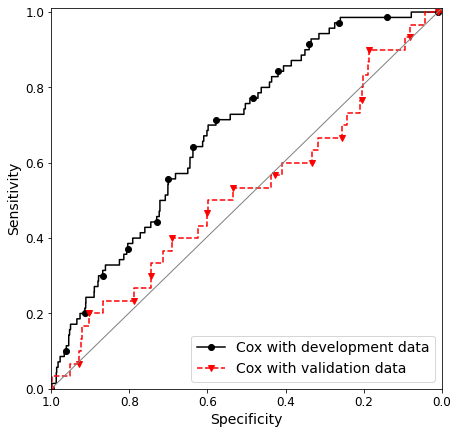

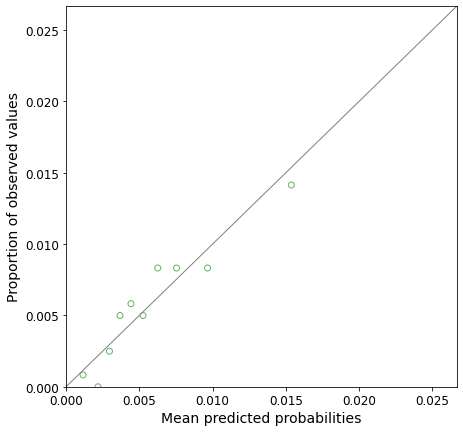

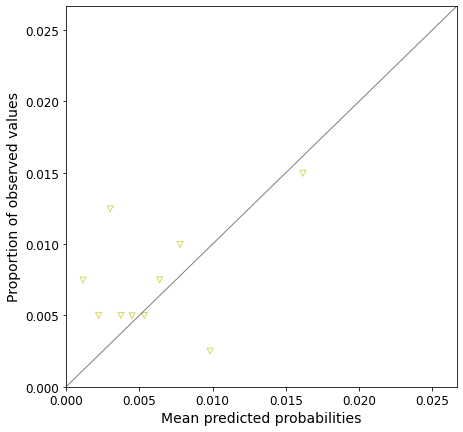

In [41]:
#data prep
data, data_uti_abs_incdt_enc = cox_data_prep(data_uti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'abs_incdt', data_uti_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'abs_incdt', data_uti_abs_incdt)

try:
    #build cox model 
    cph_uti_abs_incdt, data_uti_abs_incdt_train, data_uti_abs_incdt_test = cox_model_build('uti', 'abs_incdt', data_uti_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_uti_abs_incdt, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_abs_incdt.csv', data_uti_abs_incdt_enc, data_uti_abs_incdt, 'sum_betas_cph_uti_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_uti_abs_incdt, 'event_uti_admitted', data_uti_abs_incdt_train, data_uti_abs_incdt_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_uti_abs_incdt, data_uti_abs_incdt_train, 'event_uti_admitted', data_uti_abs_incdt_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_abs_incdt_train.jpg', 'calibration_cph_uti_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_uti_abs_incdt, 'uti', 'abs_incdt', data_uti_abs_incdt_train, data_uti_abs_incdt_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent uti with no antibiotics

<lifelines.CoxPHFitter: fitted with 11999 total observations, 11921 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 11999
number of events observed = 78
   partial log-likelihood = -711.10
         time fit was run = 2023-06-28 10:49:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.31       1.37       0.37            -0.41             1.04                 0.66                 2.82
CCI_cat[T.medium]               -0.31       0.73       0.46            -1.21             0.59                 0.30                 1.81
CCI_cat[T.high]                  0.36       1.43       0.46            -0.54             1.26                 0.58                 3.54
CCI_cat[T.very_high]             0.77       2.16       0.38             0.02             1.52                 1.02                 4.57
age_cat[T.25_34]                -0.17       0.85       0.49            -1.12             0.79                 0.33                 2.19
age_cat[T.35_44]                 0.57       1.77       0.42            -0.26             1.40                 0.77                 4.05
age_cat[T.45_54]                 0.32       1.38       0.44            -0.54             1.19                 0.58                 3.28
age_cat[T.55_64]                 0.25       1.28       0.44            -0.62             1.12                 0.54                 3.05
age_cat[T.65_74]                 0.37       1.44       0.43            -0.48             1.22                 0.62                 3.38
age_cat[T.75_more]               0.02       1.02       0.47            -0.90             0.95                 0.41                 2.58
antibacterial_brit               0.03       1.03       0.08            -0.12             0.19                 0.89                 1.20
bmi_cat[T.obese]                -0.57       0.56       0.36            -1.28             0.13                 0.28                 1.14
bmi_cat[T.overweight]           -0.79       0.45       0.52            -1.81             0.22                 0.16                 1.25
bmi_cat[T.underweight]           0.07       1.07       0.59            -1.10             1.23                 0.33                 3.43
bmi_cat[T.unknown]              -0.25       0.78       0.38            -0.99             0.49                 0.37                 1.63
ethnicity[T.unknown]             0.27       1.30       0.39            -0.49             1.02                 0.61                 2.77
ethnicity[T.white]               0.22       1.25       0.35            -0.46             0.91                 0.63                 2.48
flu_vaccine[T.yes]              -0.08       0.92       0.40            -0.86             0.70                 0.42                 2.01
imd[T.medium]                   -0.22       0.80       0.39            -0.98             0.54                 0.37                 1.71
imd[T.unaffluent]               -0.38       0.69       0.41            -1.18             0.42                 0.31                 1.53
imd[T.unknown]                   0.78       2.18       0.44            -0.08             1.64                 0.92                 5.17
imd[T.very_affluent]            -0.12       0.88       0.37            -0.85             0.61                 0.43                 1.84
imd[T.very_unaffluent]           0.27       1.32       0.35            -0.40             0.95                 0.67                 2.59
region[T.east_midlands]         -1.02       0.36       0.67            -2.33             0.29                 0.10                 1.33
region[T.london]                -0.33       0.72       0.44            -

12764


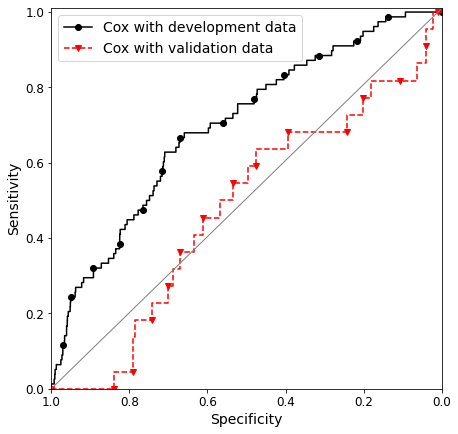

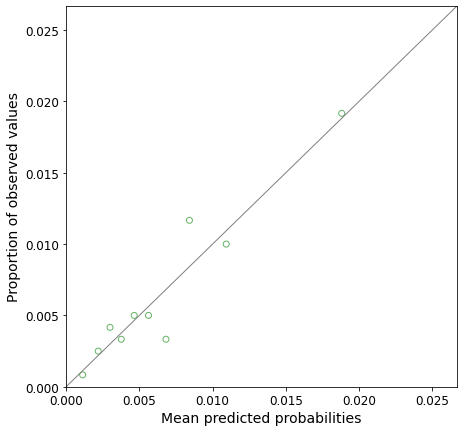

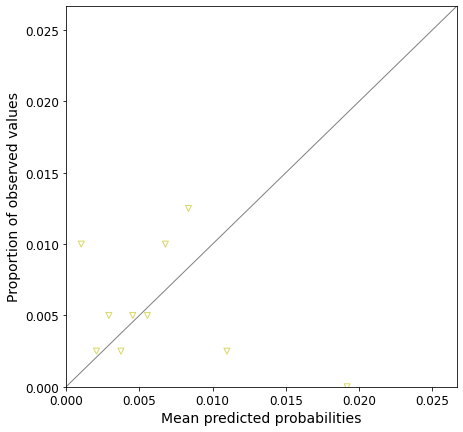

In [42]:
#data prep
data, data_uti_no_abs_prevl_enc = cox_data_prep(data_uti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'no_abs_prevl', data_uti_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'no_abs_prevl', data_uti_no_abs_prevl)

try:
    #build cox model 
    cph_uti_no_abs_prevl, data_uti_no_abs_prevl_train, data_uti_no_abs_prevl_test = cox_model_build('uti', 'no_abs_prevl', data_uti_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_uti_no_abs_prevl, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_no_abs_prevl.csv', data_uti_no_abs_prevl_enc, data_uti_no_abs_prevl, 'sum_betas_cph_uti_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_uti_no_abs_prevl, 'event_uti_admitted', data_uti_no_abs_prevl_train, data_uti_no_abs_prevl_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_uti_no_abs_prevl, data_uti_no_abs_prevl_train, 'event_uti_admitted', data_uti_no_abs_prevl_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_no_abs_prevl_train.jpg', 'calibration_cph_uti_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_uti_no_abs_prevl, 'uti', 'no_abs_prevl', data_uti_no_abs_prevl_train, data_uti_no_abs_prevl_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent uti with antibiotics

<lifelines.CoxPHFitter: fitted with 1344 total observations, 1330 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1344
number of events observed = 14
   partial log-likelihood = -70.34
         time fit was run = 2023-06-28 10:49:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.60       0.55       0.76            -2.09             0.88                 0.12                 2.41
CCI_cat[T.medium]               -0.89       0.41       0.95            -2.75             0.96                 0.06                 2.61
CCI_cat[T.high]                -19.74       0.00    9591.96        -18819.65         18780.16                 0.00                  inf
CCI_cat[T.very_high]            -0.14       0.87       0.90            -1.90             1.61                 0.15                 5.02
age_cat[T.25_34]                 2.05       7.81       1.15            -0.19             4.30                 0.83                73.67
age_cat[T.35_44]                 0.55       1.74       1.21            -1.82             2.93                 0.16                18.73
age_cat[T.45_54]               -19.08       0.00    9214.86        -18079.88         18041.72                 0.00                  inf
age_cat[T.55_64]                 1.84       6.29       1.10            -0.32             4.00                 0.73                54.36
age_cat[T.65_74]               -18.57       0.00   10338.84        -20282.33         20245.18                 0.00                  inf
age_cat[T.75_more]               0.15       1.17       1.19            -2.18             2.49                 0.11                12.05
antibacterial_brit               0.27       1.31       0.22            -0.15             0.70                 0.86                 2.00
bmi_cat[T.obese]                 0.64       1.90       1.14            -1.60             2.87                 0.20                17.72
bmi_cat[T.overweight]            0.72       2.06       1.28            -1.79             3.24                 0.17                25.55
bmi_cat[T.underweight]           1.64       5.15       1.64            -1.57             4.85                 0.21               127.90
bmi_cat[T.unknown]              -1.29       0.27       1.48            -4.19             1.61                 0.02                 4.98
ethnicity[T.unknown]            20.28   6.45e+08    8760.62        -17150.22         17190.79                 0.00                  inf
ethnicity[T.white]              19.62   3.32e+08    8760.62        -17150.88         17190.13                 0.00                  inf
flu_vaccine[T.yes]             -19.46       0.00   11963.04        -23466.58         23427.67                 0.00                  inf
imd[T.medium]                   21.66   2.54e+09    7135.79        -13964.23         14007.54                 0.00                  inf
imd[T.unaffluent]               20.08   5.24e+08    7135.79        -13965.81         14005.96                 0.00                  inf
imd[T.unknown]                  21.18   1.58e+09    7135.79        -13964.71         14007.07                 0.00                  inf
imd[T.very_affluent]            20.70   9.77e+08    7135.79        -13965.19         14006.59                 0.00                  inf
imd[T.very_unaffluent]          19.89   4.35e+08    7135.79        -13965.99         14005.78                 0.00                  inf
region[T.east_midlands]         20.61   8.90e+08   11183.73        -21899.10         21940.31                 0.00                  inf
region[T.london]                20.05   5.10e+08   11183.73        -21899.66

13038


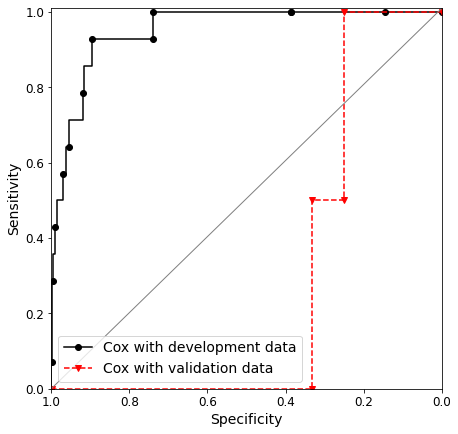

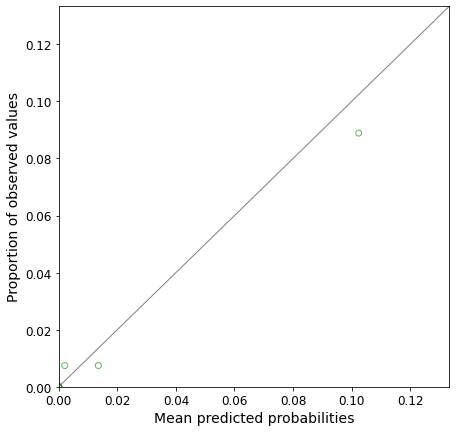

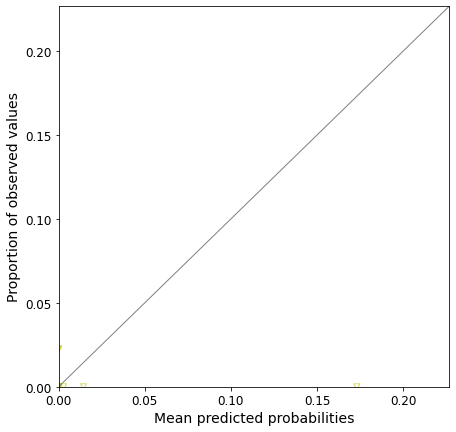

In [43]:
#data prep
data, data_uti_abs_prevl_enc = cox_data_prep(data_uti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'abs_prevl', data_uti_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'abs_prevl', data_uti_abs_prevl)

try:
    #build cox model 
    cph_uti_abs_prevl, data_uti_abs_prevl_train, data_uti_abs_prevl_test = cox_model_build('uti', 'abs_prevl', data_uti_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_uti_abs_prevl, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_abs_prevl.csv', data_uti_abs_prevl_enc, data_uti_abs_prevl, 'sum_betas_cph_uti_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_uti_abs_prevl, 'event_uti_admitted', data_uti_abs_prevl_train, data_uti_abs_prevl_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_uti_abs_prevl, data_uti_abs_prevl_train, 'event_uti_admitted', data_uti_abs_prevl_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_abs_prevl_train.jpg', 'calibration_cph_uti_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_uti_abs_prevl, 'uti', 'abs_prevl', data_uti_abs_prevl_train, data_uti_abs_prevl_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- hospital admission related to incident uti

In [44]:
#data prep
data, data_uti_incdt_enc = cox_data_prep(data_uti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary tables from preped data
make_summary_table('uti', 'incdt', data_uti_incdt_enc)
make_summary_table_hosped('uti', 'incdt', data_uti_incdt)

try:
    cph_uti_incdt, data_uti_incdt_train, data_uti_incdt_test = cox_model_abs_build('uti', 'incdt', data_uti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_incdt, 'uti', 'incdt', data_uti_incdt_train, data_uti_incdt_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 120081 total observations, 119320 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 120081
number of events observed = 761
   partial log-likelihood = -8878.62
         time fit was run = 2023-06-28 10:50:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.11            -0.18             0.26                 0.84                 1.30
CCI_cat[T.medium]                0.12       1.12       0.12            -0.12             0.36                 0.88                 1.43
CCI_cat[T.high]                  0.15       1.16       0.14            -0.13             0.43                 0.88                 1.54
CCI_cat[T.very_high]             0.28       1.33       0.12             0.04             0.52                 1.04                 1.69
age_cat[T.25_34]                -0.01       0.99       0.14            -0.28             0.25                 0.76                 1.29
age_cat[T.35_44]                -0.15       0.86       0.14            -0.43             0.13                 0.65                 1.13
age_cat[T.45_54]                 0.02       1.02       0.14            -0.25             0.28                 0.78                 1.32
age_cat[T.55_64]                -0.00       1.00       0.14            -0.27             0.26                 0.77                 1.30
age_cat[T.65_74]                 0.03       1.03       0.13            -0.24             0.29                 0.79                 1.34
age_cat[T.75_more]               0.04       1.04       0.13            -0.22             0.30                 0.80                 1.35
antibacterial_brit              -0.05       0.95       0.03            -0.10            -0.00                 0.90                 1.00
bmi_cat[T.obese]                 0.09       1.09       0.14            -0.18             0.36                 0.83                 1.43
bmi_cat[T.overweight]           -0.01       0.99       0.17            -0.34             0.33                 0.71                 1.39
bmi_cat[T.underweight]           0.04       1.04       0.24            -0.44             0.51                 0.65                 1.66
bmi_cat[T.unknown]               0.02       1.02       0.15            -0.27             0.31                 0.76                 1.37
ethnicity[T.unknown]             0.07       1.08       0.12            -0.16             0.31                 0.85                 1.36
ethnicity[T.white]               0.03       1.03       0.11            -0.18             0.24                 0.83                 1.27
flu_vaccine[T.yes]              -0.01       0.99       0.12            -0.24             0.23                 0.78                 1.26
imd[T.medium]                   -0.02       0.98       0.11            -0.25             0.20                 0.78                 1.22
imd[T.unaffluent]               -0.01       0.99       0.11            -0.23             0.21                 0.79                 1.24
imd[T.unknown]                  -0.10       0.90       0.18            -0.46             0.26                 0.63                 1.30
imd[T.very_affluent]            -0.05       0.95       0.11            -0.28             0.17                 0.76                 1.19
imd[T.very_unaffluent]          -0.34       0.71       0.12            -0.58            -0.10                 0.56                 0.90
region[T.east_midlands]         -0.19       0.82       0.17            -0.53             0.14                 0.59                 1.15
region[T.london]                 0.00       1.00       0.14        

13037


### 5-6- hospital admission related to prevalent uti

In [45]:
#data prep
data, data_uti_prevl_enc = cox_data_prep(data_uti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary tables from preped data
make_summary_table('uti', 'prevl', data_uti_prevl_enc)
make_summary_table_hosped('uti', 'prevl', data_uti_prevl)

try:
    cph_uti_prevl, data_uti_prevl_train, data_uti_prevl_test = cox_model_abs_build('uti', 'prevl', data_uti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_prevl, 'uti', 'prevl', data_uti_prevl_train, data_uti_prevl_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13343 total observations, 13258 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 13343
number of events observed = 85
   partial log-likelihood = -786.68
         time fit was run = 2023-06-28 10:50:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.36       1.43       0.35            -0.33             1.04                 0.72                 2.82
CCI_cat[T.medium]               -0.34       0.71       0.44            -1.20             0.52                 0.30                 1.68
CCI_cat[T.high]                  0.10       1.11       0.47            -0.81             1.02                 0.45                 2.76
CCI_cat[T.very_high]             0.68       1.98       0.37            -0.04             1.41                 0.96                 4.09
age_cat[T.25_34]                -0.44       0.65       0.41            -1.24             0.37                 0.29                 1.44
age_cat[T.35_44]                -0.05       0.95       0.37            -0.78             0.68                 0.46                 1.98
age_cat[T.45_54]                -0.31       0.73       0.40            -1.09             0.47                 0.34                 1.60
age_cat[T.55_64]                -0.13       0.88       0.38            -0.88             0.61                 0.42                 1.85
age_cat[T.65_74]                -0.22       0.80       0.39            -0.98             0.54                 0.38                 1.72
age_cat[T.75_more]              -0.40       0.67       0.41            -1.20             0.41                 0.30                 1.50
antibacterial_brit               0.07       1.07       0.07            -0.07             0.22                 0.93                 1.24
bmi_cat[T.obese]                -0.46       0.63       0.36            -1.15             0.24                 0.32                 1.27
bmi_cat[T.overweight]           -0.19       0.83       0.44            -1.04             0.67                 0.35                 1.96
bmi_cat[T.underweight]           0.43       1.53       0.52            -0.59             1.44                 0.55                 4.24
bmi_cat[T.unknown]              -0.51       0.60       0.39            -1.28             0.25                 0.28                 1.29
ethnicity[T.unknown]            -0.25       0.78       0.35            -0.92             0.43                 0.40                 1.54
ethnicity[T.white]              -0.10       0.90       0.29            -0.68             0.47                 0.51                 1.61
flu_vaccine[T.yes]               0.11       1.12       0.35            -0.58             0.80                 0.56                 2.24
imd[T.medium]                   -0.22       0.81       0.37            -0.95             0.52                 0.39                 1.68
imd[T.unaffluent]               -0.45       0.64       0.40            -1.24             0.34                 0.29                 1.40
imd[T.unknown]                   0.67       1.95       0.43            -0.18             1.52                 0.83                 4.57
imd[T.very_affluent]            -0.01       0.99       0.35            -0.70             0.69                 0.50                 1.98
imd[T.very_unaffluent]           0.30       1.34       0.33            -0.35             0.94                 0.70                 2.56
region[T.east_midlands]         -0.17       0.84       0.67            -1.49             1.15                 0.23                 3.15
region[T.london]                 0.64       1.90       0.51            -

13038


### 5-7- hospital admission related to incident uti with prescribed antibiotics categories

In [46]:
#data prep
data, data_uti_incdt_abs_enc = cox_data_prep(data_uti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_abs, data_uti_incdt_abs_train, data_uti_incdt_abs_test = cox_model_ab_type_build('uti', 'incdt_ab_type', data_uti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_abs, 'uti', 'incdt_abs', data_uti_incdt_abs_train, data_uti_incdt_abs_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 120081 total observations, 119320 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 120081
number of events observed = 761
   partial log-likelihood = -8877.16
         time fit was run = 2023-06-28 10:50:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.11            -0.18             0.26                 0.84                 1.30
CCI_cat[T.medium]                0.12       1.12       0.12            -0.12             0.36                 0.88                 1.43
CCI_cat[T.high]                  0.15       1.16       0.14            -0.13             0.43                 0.88                 1.54
CCI_cat[T.very_high]             0.28       1.33       0.12             0.04             0.52                 1.04                 1.69
ab_type_cat[T.Doxycycline]      -0.32       0.73       0.78            -1.85             1.21                 0.16                 3.37
ab_type_cat[T.no]               -0.66       0.52       0.34            -1.31             0.00                 0.27                 1.00
ab_type_cat[T.other]            -0.64       0.53       0.35            -1.33             0.05                 0.26                 1.06
age_cat[T.25_34]                -0.01       0.99       0.14            -0.27             0.26                 0.76                 1.29
age_cat[T.35_44]                -0.15       0.86       0.14            -0.43             0.13                 0.65                 1.13
age_cat[T.45_54]                 0.02       1.02       0.14            -0.25             0.28                 0.78                 1.33
age_cat[T.55_64]                -0.00       1.00       0.14            -0.27             0.26                 0.77                 1.30
age_cat[T.65_74]                 0.03       1.03       0.13            -0.24             0.29                 0.79                 1.34
age_cat[T.75_more]               0.04       1.04       0.13            -0.22             0.30                 0.80                 1.35
antibacterial_brit              -0.05       0.95       0.03            -0.10            -0.00                 0.90                 1.00
bmi_cat[T.obese]                 0.09       1.09       0.14            -0.18             0.36                 0.83                 1.43
bmi_cat[T.overweight]           -0.01       1.00       0.17            -0.34             0.33                 0.71                 1.39
bmi_cat[T.underweight]           0.04       1.04       0.24            -0.44             0.51                 0.65                 1.67
bmi_cat[T.unknown]               0.02       1.02       0.15            -0.27             0.31                 0.77                 1.37
ethnicity[T.unknown]             0.07       1.08       0.12            -0.16             0.31                 0.85                 1.36
ethnicity[T.white]               0.03       1.03       0.11            -0.18             0.24                 0.83                 1.27
flu_vaccine[T.yes]              -0.01       0.99       0.12            -0.24             0.23                 0.78                 1.26
imd[T.medium]                   -0.02       0.98       0.11            -0.25             0.20                 0.78                 1.22
imd[T.unaffluent]               -0.01       0.99       0.11            -0.23             0.21                 0.79                 1.24
imd[T.unknown]                  -0.10       0.90       0.18            -0.46             0.26                 0.63                 1.30
imd[T.very_affluent]            -0.05       0.95       0.11        

13607


### 5-8- hospital admission related to prevalent uti with prescribed antibiotics categories

In [47]:
#data prep
data, data_uti_prevl_abs_enc = cox_data_prep(data_uti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_abs, data_uti_prevl_abs_train, data_uti_prevl_abs_test = cox_model_ab_type_build('uti', 'prevl_ab_type', data_uti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_abs, 'uti', 'prevl_abs', data_uti_prevl_abs_train, data_uti_prevl_abs_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13343 total observations, 13258 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 13343
number of events observed = 85
   partial log-likelihood = -786.26
         time fit was run = 2023-06-28 10:50:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.35       1.43       0.35            -0.33             1.04                 0.72                 2.82
CCI_cat[T.medium]               -0.34       0.71       0.44            -1.20             0.52                 0.30                 1.68
CCI_cat[T.high]                  0.10       1.11       0.47            -0.81             1.02                 0.44                 2.76
CCI_cat[T.very_high]             0.69       1.99       0.37            -0.04             1.42                 0.96                 4.12
ab_type_cat[T.Doxycycline]     -14.69       0.00    2139.37         -4207.79          4178.40                 0.00                  inf
ab_type_cat[T.no]               -0.83       0.44       1.01            -2.81             1.15                 0.06                 3.17
ab_type_cat[T.other]            -0.38       0.69       1.05            -2.43             1.67                 0.09                 5.33
age_cat[T.25_34]                -0.43       0.65       0.41            -1.23             0.37                 0.29                 1.45
age_cat[T.35_44]                -0.05       0.96       0.37            -0.78             0.68                 0.46                 1.98
age_cat[T.45_54]                -0.31       0.73       0.40            -1.09             0.47                 0.34                 1.60
age_cat[T.55_64]                -0.13       0.88       0.38            -0.87             0.62                 0.42                 1.85
age_cat[T.65_74]                -0.21       0.81       0.39            -0.97             0.55                 0.38                 1.73
age_cat[T.75_more]              -0.39       0.67       0.41            -1.20             0.41                 0.30                 1.51
antibacterial_brit               0.07       1.07       0.07            -0.07             0.22                 0.93                 1.24
bmi_cat[T.obese]                -0.46       0.63       0.36            -1.15             0.24                 0.32                 1.27
bmi_cat[T.overweight]           -0.19       0.83       0.44            -1.05             0.67                 0.35                 1.95
bmi_cat[T.underweight]           0.42       1.53       0.52            -0.59             1.44                 0.55                 4.22
bmi_cat[T.unknown]              -0.52       0.60       0.39            -1.28             0.25                 0.28                 1.29
ethnicity[T.unknown]            -0.25       0.78       0.35            -0.93             0.43                 0.40                 1.53
ethnicity[T.white]              -0.10       0.90       0.29            -0.68             0.47                 0.51                 1.61
flu_vaccine[T.yes]               0.11       1.12       0.35            -0.58             0.80                 0.56                 2.24
imd[T.medium]                   -0.22       0.80       0.37            -0.95             0.51                 0.39                 1.67
imd[T.unaffluent]               -0.45       0.64       0.40            -1.24             0.34                 0.29                 1.41
imd[T.unknown]                   0.66       1.94       0.43            -0.19             1.51                 0.83                 4.54
imd[T.very_affluent]            -0.02       0.98       0.35            -

13617


### 5-9- stratified by sex
#### 5-9-1- incident males

In [48]:
#data prep
data, data_uti_incdt_males_enc = cox_data_prep(data_uti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_males, data_uti_incdt_males_train, data_uti_incdt_males_test = cox_model_strat_sex_build('uti', 'incdt_males', data_uti_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_males, 'uti', 'incdt_males', data_uti_incdt_males_train, data_uti_incdt_males_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 58547 total observations, 58155 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 58547
number of events observed = 392
   partial log-likelihood = -4284.53
         time fit was run = 2023-06-28 10:50:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.22       1.25       0.16            -0.09             0.53                 0.92                 1.70
CCI_cat[T.medium]                0.23       1.26       0.17            -0.11             0.57                 0.90                 1.77
CCI_cat[T.high]                  0.21       1.24       0.20            -0.19             0.61                 0.83                 1.84
CCI_cat[T.very_high]             0.13       1.14       0.18            -0.23             0.49                 0.79                 1.63
age_cat[T.25_34]                -0.01       0.99       0.19            -0.38             0.36                 0.69                 1.43
age_cat[T.35_44]                -0.25       0.78       0.20            -0.64             0.14                 0.53                 1.16
age_cat[T.45_54]                 0.02       1.02       0.19            -0.34             0.39                 0.71                 1.48
age_cat[T.55_64]                -0.10       0.91       0.19            -0.47             0.28                 0.62                 1.32
age_cat[T.65_74]                 0.03       1.03       0.19            -0.34             0.40                 0.72                 1.49
age_cat[T.75_more]               0.06       1.06       0.19            -0.30             0.42                 0.74                 1.52
antibacterial_brit               0.02       1.02       0.04            -0.05             0.09                 0.95                 1.09
bmi_cat[T.obese]                 0.07       1.07       0.19            -0.30             0.44                 0.74                 1.55
bmi_cat[T.overweight]           -0.09       0.91       0.24            -0.56             0.38                 0.57                 1.46
bmi_cat[T.underweight]           0.02       1.02       0.33            -0.62             0.67                 0.54                 1.95
bmi_cat[T.unknown]              -0.04       0.96       0.20            -0.44             0.36                 0.64                 1.43
ethnicity[T.unknown]            -0.06       0.94       0.17            -0.39             0.27                 0.68                 1.31
ethnicity[T.white]               0.03       1.03       0.15            -0.26             0.31                 0.77                 1.37
flu_vaccine[T.yes]              -0.16       0.85       0.18            -0.51             0.19                 0.60                 1.21
imd[T.medium]                    0.05       1.05       0.16            -0.27             0.36                 0.76                 1.43
imd[T.unaffluent]                0.02       1.02       0.16            -0.30             0.33                 0.74                 1.40
imd[T.unknown]                   0.27       1.31       0.23            -0.18             0.72                 0.83                 2.06
imd[T.very_affluent]             0.00       1.00       0.16            -0.31             0.32                 0.73                 1.38
imd[T.very_unaffluent]          -0.35       0.70       0.18            -0.70            -0.01                 0.50                 0.99
region[T.east_midlands]         -0.50       0.61       0.24            -0.96            -0.04                 0.38                 0.96
region[T.london]                -0.25       0.78       0.19           

12774


#### 5-9-2- incident females

In [49]:
#data prep
data, data_uti_incdt_females_enc = cox_data_prep(data_uti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_females, data_uti_incdt_females_train, data_uti_incdt_females_test = cox_model_strat_sex_build('uti', 'incdt_females', data_uti_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_females, 'uti', 'incdt_females', data_uti_incdt_females_train, data_uti_incdt_females_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61534 total observations, 61156 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 61534
number of events observed = 378
   partial log-likelihood = -4151.50
         time fit was run = 2023-06-28 10:50:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.20       0.82       0.16            -0.51             0.11                 0.60                 1.11
CCI_cat[T.medium]                0.02       1.02       0.17            -0.31             0.34                 0.73                 1.41
CCI_cat[T.high]                 -0.01       0.99       0.20            -0.40             0.38                 0.67                 1.47
CCI_cat[T.very_high]             0.25       1.28       0.17            -0.08             0.57                 0.92                 1.77
age_cat[T.25_34]                 0.01       1.01       0.19            -0.35             0.37                 0.70                 1.45
age_cat[T.35_44]                -0.24       0.79       0.20            -0.62             0.15                 0.54                 1.16
age_cat[T.45_54]                -0.02       0.98       0.19            -0.39             0.34                 0.68                 1.41
age_cat[T.55_64]                -0.11       0.89       0.19            -0.49             0.26                 0.61                 1.30
age_cat[T.65_74]                -0.05       0.95       0.19            -0.42             0.32                 0.66                 1.37
age_cat[T.75_more]              -0.11       0.89       0.19            -0.49             0.26                 0.62                 1.30
antibacterial_brit              -0.08       0.92       0.04            -0.15            -0.00                 0.86                 1.00
bmi_cat[T.obese]                 0.14       1.14       0.20            -0.26             0.53                 0.77                 1.70
bmi_cat[T.overweight]            0.10       1.10       0.24            -0.38             0.58                 0.68                 1.78
bmi_cat[T.underweight]           0.20       1.22       0.34            -0.46             0.86                 0.63                 2.36
bmi_cat[T.unknown]               0.11       1.11       0.21            -0.31             0.53                 0.73                 1.70
ethnicity[T.unknown]             0.02       1.02       0.16            -0.30             0.34                 0.74                 1.40
ethnicity[T.white]              -0.11       0.90       0.15            -0.39             0.18                 0.68                 1.20
flu_vaccine[T.yes]              -0.17       0.84       0.18            -0.53             0.18                 0.59                 1.20
imd[T.medium]                   -0.15       0.86       0.16            -0.46             0.17                 0.63                 1.18
imd[T.unaffluent]               -0.16       0.85       0.16            -0.48             0.16                 0.62                 1.17
imd[T.unknown]                  -0.22       0.80       0.27            -0.74             0.30                 0.47                 1.35
imd[T.very_affluent]            -0.28       0.76       0.17            -0.61             0.05                 0.55                 1.05
imd[T.very_unaffluent]          -0.14       0.87       0.16            -0.45             0.17                 0.64                 1.19
region[T.east_midlands]         -0.33       0.72       0.25            -0.83             0.17                 0.44                 1.18
region[T.london]                -0.02       0.98       0.20           

12781


#### 5-9-3- prevalent males

In [50]:
#data prep
data, data_uti_prevl_males_enc = cox_data_prep(data_uti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_males, data_uti_prevl_males_train, data_uti_prevl_males_test = cox_model_strat_sex_build('uti', 'prevl_males', data_uti_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_uti_prevl_males, 'uti', 'prevl_males', data_uti_prevl_males_train, data_uti_prevl_males_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6493 total observations, 6451 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 6493
number of events observed = 42
   partial log-likelihood = -347.16
         time fit was run = 2023-06-28 10:50:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.08       2.95       0.63            -0.15             2.31                 0.86                10.11
CCI_cat[T.medium]                0.10       1.11       0.77            -1.40             1.60                 0.25                 4.98
CCI_cat[T.high]                  0.57       1.76       0.82            -1.04             2.17                 0.35                 8.78
CCI_cat[T.very_high]             1.66       5.25       0.64             0.41             2.90                 1.51                18.24
age_cat[T.25_34]                -0.24       0.79       0.67            -1.56             1.08                 0.21                 2.95
age_cat[T.35_44]                 0.17       1.19       0.61            -1.02             1.36                 0.36                 3.90
age_cat[T.45_54]                 0.25       1.28       0.59            -0.91             1.40                 0.40                 4.05
age_cat[T.55_64]                 0.17       1.18       0.61            -1.02             1.36                 0.36                 3.91
age_cat[T.65_74]                 0.65       1.91       0.56            -0.45             1.75                 0.64                 5.74
age_cat[T.75_more]               0.01       1.01       0.64            -1.24             1.25                 0.29                 3.50
antibacterial_brit              -0.00       1.00       0.11            -0.22             0.21                 0.80                 1.24
bmi_cat[T.obese]                -0.67       0.51       0.47            -1.58             0.24                 0.21                 1.27
bmi_cat[T.overweight]           -1.09       0.34       0.71            -2.48             0.31                 0.08                 1.36
bmi_cat[T.underweight]          -0.10       0.90       0.82            -1.72             1.51                 0.18                 4.52
bmi_cat[T.unknown]              -0.86       0.42       0.53            -1.90             0.19                 0.15                 1.20
ethnicity[T.unknown]            -0.14       0.87       0.58            -1.27             0.99                 0.28                 2.69
ethnicity[T.white]               0.40       1.49       0.49            -0.56             1.35                 0.57                 3.86
flu_vaccine[T.yes]              -0.31       0.73       0.60            -1.49             0.87                 0.23                 2.39
imd[T.medium]                   -0.08       0.92       0.47            -1.01             0.85                 0.36                 2.34
imd[T.unaffluent]               -0.84       0.43       0.60            -2.02             0.34                 0.13                 1.41
imd[T.unknown]                   0.21       1.23       0.67            -1.10             1.53                 0.33                 4.60
imd[T.very_affluent]            -0.87       0.42       0.60            -2.05             0.32                 0.13                 1.37
imd[T.very_unaffluent]           0.35       1.42       0.44            -0.51             1.21                 0.60                 3.34
region[T.east_midlands]         -1.39       0.25       1.12            -3.58             0.81                 0.03                 2.24
region[T.london]                 0.25       1.28       0.60            -0.9

12759


#### 5-9-4- prevalent females

In [51]:
try:
    #data prep
    data, data_uti_prevl_females_enc = cox_data_prep(data_uti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

    #cox model
    cph_uti_prevl_females, data_uti_prevl_females_train, data_uti_prevl_females_test = cox_model_strat_sex_build('uti', 'prevl_females', data_uti_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_females, 'uti', 'prevl_females', data_uti_prevl_females_train, data_uti_prevl_females_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6849 total observations, 6799 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 6849
number of events observed = 50
   partial log-likelihood = -427.56
         time fit was run = 2023-06-28 10:50:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.11       0.40            -0.68             0.89                 0.51                 2.43
CCI_cat[T.medium]               -0.39       0.68       0.51            -1.38             0.60                 0.25                 1.83
CCI_cat[T.high]                 -0.41       0.66       0.60            -1.60             0.77                 0.20                 2.16
CCI_cat[T.very_high]            -0.01       0.99       0.47            -0.94             0.92                 0.39                 2.52
age_cat[T.25_34]                 0.32       1.38       0.49            -0.65             1.29                 0.52                 3.63
age_cat[T.35_44]                -0.01       0.99       0.54            -1.06             1.04                 0.35                 2.84
age_cat[T.45_54]                 0.11       1.12       0.52            -0.91             1.13                 0.40                 3.08
age_cat[T.55_64]                 0.16       1.18       0.52            -0.85             1.18                 0.43                 3.26
age_cat[T.65_74]                -1.23       0.29       0.80            -2.80             0.34                 0.06                 1.41
age_cat[T.75_more]               0.10       1.10       0.52            -0.92             1.11                 0.40                 3.05
antibacterial_brit               0.04       1.04       0.10            -0.15             0.23                 0.86                 1.26
bmi_cat[T.obese]                 0.37       1.44       0.61            -0.83             1.56                 0.44                 4.77
bmi_cat[T.overweight]            0.43       1.53       0.71            -0.96             1.81                 0.38                 6.14
bmi_cat[T.underweight]           0.63       1.88       0.92            -1.16             2.43                 0.31                11.32
bmi_cat[T.unknown]               0.32       1.38       0.64            -0.94             1.58                 0.39                 4.85
ethnicity[T.unknown]             0.08       1.08       0.42            -0.75             0.91                 0.47                 2.48
ethnicity[T.white]              -0.24       0.78       0.39            -1.01             0.52                 0.37                 1.68
flu_vaccine[T.yes]              -0.46       0.63       0.60            -1.63             0.71                 0.20                 2.03
imd[T.medium]                   -0.48       0.62       0.56            -1.57             0.62                 0.21                 1.86
imd[T.unaffluent]               -0.06       0.94       0.49            -1.01             0.90                 0.36                 2.45
imd[T.unknown]                   1.06       2.88       0.53             0.02             2.10                 1.02                 8.13
imd[T.very_affluent]             0.19       1.20       0.46            -0.72             1.09                 0.49                 2.97
imd[T.very_unaffluent]           0.32       1.38       0.44            -0.55             1.19                 0.58                 3.28
region[T.east_midlands]          0.60       1.82       0.73            -0.84             2.04                 0.43                 7.66
region[T.london]                 0.69       2.00       0.65            -0.5

12753


### 5-10- stratified by age category
#### 5-10-1- incident

In [52]:
#data prep
data, data_uti_incdt_15_24_enc = cox_data_prep(data_uti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_15_24, data_uti_incdt_15_24_train, data_uti_incdt_15_24_test = cox_model_strat_age_build('uti', 'incdt_15_24', data_uti_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_15_24, 'uti', 'incdt_15_24', data_uti_incdt_15_24_train, data_uti_incdt_15_24_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16918 total observations, 16802 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 16918
number of events observed = 116
   partial log-likelihood = -1108.84
         time fit was run = 2023-06-28 10:50:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.45       1.56       0.31            -0.15             1.05                 0.86                 2.85
CCI_cat[T.medium]                0.20       1.22       0.35            -0.48             0.87                 0.62                 2.40
CCI_cat[T.high]                  0.15       1.16       0.41            -0.66             0.96                 0.52                 2.62
CCI_cat[T.very_high]             0.69       1.99       0.33             0.04             1.34                 1.04                 3.82
antibacterial_brit              -0.11       0.90       0.07            -0.24             0.03                 0.79                 1.03
bmi_cat[T.obese]                 0.63       1.88       0.43            -0.21             1.47                 0.81                 4.33
bmi_cat[T.overweight]            0.47       1.60       0.50            -0.51             1.45                 0.60                 4.26
bmi_cat[T.underweight]           0.94       2.56       0.58            -0.19             2.07                 0.82                 7.94
bmi_cat[T.unknown]               0.32       1.38       0.45            -0.57             1.21                 0.56                 3.35
ethnicity[T.unknown]            -0.19       0.83       0.29            -0.76             0.38                 0.47                 1.46
ethnicity[T.white]              -0.20       0.82       0.26            -0.70             0.30                 0.50                 1.35
flu_vaccine[T.yes]              -0.53       0.59       0.39            -1.29             0.24                 0.28                 1.27
imd[T.medium]                   -0.31       0.73       0.32            -0.94             0.31                 0.39                 1.36
imd[T.unaffluent]                0.03       1.03       0.28            -0.53             0.58                 0.59                 1.79
imd[T.unknown]                  -0.01       0.99       0.46            -0.90             0.89                 0.41                 2.43
imd[T.very_affluent]            -0.18       0.84       0.30            -0.76             0.41                 0.47                 1.50
imd[T.very_unaffluent]          -0.15       0.86       0.30            -0.73             0.43                 0.48                 1.53
region[T.east_midlands]         -0.19       0.83       0.45            -1.07             0.69                 0.34                 2.00
region[T.london]                 0.05       1.05       0.37            -0.68             0.77                 0.51                 2.16
region[T.north_east]            -0.17       0.85       0.45            -1.05             0.71                 0.35                 2.04
region[T.north_west]             0.08       1.08       0.42            -0.74             0.90                 0.48                 2.46
region[T.south_east]             0.17       1.18       0.41            -0.64             0.97                 0.53                 2.65
region[T.south_west]            -0.08       0.92       0.44            -0.94             0.78                 0.39                 2.17
region[T.west_midlands]          0.52       1.68       0.38            -0.23             1.27                 0.79                 3.56
region[T.yorkshire]              0.03       1.03       0.42           

11399


In [53]:
#data prep
data, data_uti_incdt_25_34_enc = cox_data_prep(data_uti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_25_34, data_uti_incdt_25_34_train, data_uti_incdt_25_34_test = cox_model_strat_age_build('uti', 'incdt_25_34', data_uti_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_25_34, 'uti', 'incdt_25_34', data_uti_incdt_25_34_train, data_uti_incdt_25_34_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17411 total observations, 17299 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17411
number of events observed = 112
   partial log-likelihood = -1076.57
         time fit was run = 2023-06-28 10:50:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.00       1.00       0.30            -0.58             0.58                 0.56                 1.79
CCI_cat[T.medium]               -0.17       0.84       0.34            -0.84             0.50                 0.43                 1.65
CCI_cat[T.high]                  0.26       1.30       0.37            -0.46             0.99                 0.63                 2.68
CCI_cat[T.very_high]             0.62       1.86       0.30             0.03             1.21                 1.03                 3.37
antibacterial_brit              -0.18       0.84       0.07            -0.32            -0.03                 0.73                 0.97
bmi_cat[T.obese]                 0.13       1.14       0.36            -0.57             0.83                 0.57                 2.30
bmi_cat[T.overweight]           -0.08       0.93       0.45            -0.96             0.81                 0.38                 2.24
bmi_cat[T.underweight]           0.59       1.80       0.53            -0.45             1.63                 0.64                 5.08
bmi_cat[T.unknown]              -0.08       0.92       0.39            -0.85             0.68                 0.43                 1.98
ethnicity[T.unknown]            -0.14       0.87       0.32            -0.76             0.48                 0.47                 1.61
ethnicity[T.white]               0.00       1.00       0.27            -0.53             0.53                 0.59                 1.70
flu_vaccine[T.yes]               0.19       1.20       0.30            -0.39             0.77                 0.67                 2.15
imd[T.medium]                   -0.29       0.75       0.32            -0.92             0.33                 0.40                 1.39
imd[T.unaffluent]               -0.25       0.78       0.31            -0.85             0.35                 0.43                 1.42
imd[T.unknown]                   0.68       1.97       0.35            -0.02             1.37                 0.98                 3.94
imd[T.very_affluent]            -0.35       0.70       0.32            -0.97             0.27                 0.38                 1.31
imd[T.very_unaffluent]          -0.05       0.95       0.29            -0.63             0.52                 0.54                 1.69
region[T.east_midlands]          0.02       1.02       0.46            -0.89             0.92                 0.41                 2.50
region[T.london]                 0.12       1.13       0.40            -0.66             0.91                 0.52                 2.47
region[T.north_east]             0.04       1.04       0.46            -0.86             0.94                 0.42                 2.56
region[T.north_west]             0.55       1.73       0.42            -0.27             1.37                 0.76                 3.93
region[T.south_east]             0.09       1.10       0.45            -0.79             0.97                 0.45                 2.65
region[T.south_west]             0.02       1.02       0.47            -0.90             0.95                 0.40                 2.57
region[T.west_midlands]          0.35       1.41       0.43            -0.51             1.20                 0.60                 3.31
region[T.yorkshire]              0.28       1.32       0.43           

11389


In [54]:
#data prep
data, data_uti_incdt_35_44_enc = cox_data_prep(data_uti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_35_44, data_uti_incdt_35_44_train, data_uti_incdt_35_44_test = cox_model_strat_age_build('uti', 'incdt_35_44', data_uti_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_35_44, 'uti', 'incdt_35_44', data_uti_incdt_35_44_train, data_uti_incdt_35_44_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17239 total observations, 17130 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17239
number of events observed = 109
   partial log-likelihood = -1046.89
         time fit was run = 2023-06-28 10:50:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.30            -0.60             0.57                 0.55                 1.76
CCI_cat[T.medium]                0.17       1.19       0.32            -0.45             0.79                 0.64                 2.21
CCI_cat[T.high]                  0.09       1.09       0.38            -0.65             0.83                 0.52                 2.28
CCI_cat[T.very_high]             0.25       1.29       0.32            -0.38             0.89                 0.68                 2.42
antibacterial_brit               0.06       1.06       0.07            -0.07             0.19                 0.93                 1.20
bmi_cat[T.obese]                 0.24       1.27       0.38            -0.50             0.97                 0.61                 2.65
bmi_cat[T.overweight]            0.17       1.19       0.45            -0.71             1.06                 0.49                 2.87
bmi_cat[T.underweight]          -0.48       0.62       0.79            -2.03             1.07                 0.13                 2.93
bmi_cat[T.unknown]              -0.21       0.81       0.42            -1.02             0.61                 0.36                 1.84
ethnicity[T.unknown]             0.51       1.66       0.32            -0.12             1.14                 0.88                 3.13
ethnicity[T.white]               0.11       1.12       0.31            -0.49             0.71                 0.61                 2.04
flu_vaccine[T.yes]               0.12       1.13       0.31            -0.48             0.72                 0.62                 2.06
imd[T.medium]                    0.03       1.03       0.30            -0.56             0.62                 0.57                 1.85
imd[T.unaffluent]                0.16       1.18       0.29            -0.41             0.74                 0.66                 2.09
imd[T.unknown]                  -0.34       0.71       0.54            -1.41             0.73                 0.25                 2.07
imd[T.very_affluent]            -0.01       0.99       0.31            -0.61             0.59                 0.54                 1.80
imd[T.very_unaffluent]          -0.45       0.64       0.34            -1.12             0.23                 0.33                 1.25
region[T.east_midlands]         -0.08       0.92       0.42            -0.90             0.74                 0.41                 2.09
region[T.london]                -0.10       0.91       0.37            -0.81             0.62                 0.44                 1.86
region[T.north_east]            -0.18       0.83       0.43            -1.02             0.66                 0.36                 1.93
region[T.north_west]            -0.48       0.62       0.48            -1.42             0.45                 0.24                 1.57
region[T.south_east]             0.30       1.34       0.38            -0.45             1.05                 0.64                 2.84
region[T.south_west]            -0.17       0.84       0.43            -1.01             0.67                 0.36                 1.95
region[T.west_midlands]         -0.52       0.60       0.48            -1.45             0.42                 0.23                 1.52
region[T.yorkshire]              0.37       1.45       0.38           

11391


In [55]:
#data prep
data, data_uti_incdt_45_54_enc = cox_data_prep(data_uti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_45_54, data_uti_incdt_45_54_train, data_uti_incdt_45_54_test = cox_model_strat_age_build('uti', 'incdt_45_54', data_uti_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_45_54, 'uti', 'incdt_45_54', data_uti_incdt_45_54_train, data_uti_incdt_45_54_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17073 total observations, 16956 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17073
number of events observed = 117
   partial log-likelihood = -1123.80
         time fit was run = 2023-06-28 10:50:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.28            -0.60             0.51                 0.55                 1.67
CCI_cat[T.medium]                0.09       1.10       0.30            -0.50             0.69                 0.61                 1.99
CCI_cat[T.high]                  0.35       1.42       0.33            -0.29             1.00                 0.75                 2.71
CCI_cat[T.very_high]            -0.04       0.96       0.33            -0.70             0.61                 0.50                 1.85
antibacterial_brit              -0.00       1.00       0.07            -0.13             0.12                 0.88                 1.13
bmi_cat[T.obese]                 0.25       1.29       0.40            -0.53             1.04                 0.59                 2.83
bmi_cat[T.overweight]            0.37       1.44       0.46            -0.54             1.27                 0.58                 3.57
bmi_cat[T.underweight]           1.13       3.09       0.51             0.14             2.12                 1.15                 8.31
bmi_cat[T.unknown]               0.27       1.31       0.42            -0.56             1.10                 0.57                 2.99
ethnicity[T.unknown]            -0.46       0.63       0.31            -1.07             0.15                 0.34                 1.17
ethnicity[T.white]              -0.06       0.94       0.25            -0.55             0.43                 0.57                 1.54
flu_vaccine[T.yes]               0.39       1.47       0.26            -0.13             0.90                 0.88                 2.46
imd[T.medium]                    0.16       1.18       0.26            -0.36             0.68                 0.70                 1.98
imd[T.unaffluent]               -0.63       0.53       0.33            -1.28             0.02                 0.28                 1.03
imd[T.unknown]                  -0.11       0.90       0.45            -1.00             0.78                 0.37                 2.18
imd[T.very_affluent]            -0.26       0.77       0.29            -0.84             0.32                 0.43                 1.37
imd[T.very_unaffluent]          -0.42       0.66       0.31            -1.02             0.18                 0.36                 1.20
region[T.east_midlands]          0.27       1.31       0.47            -0.66             1.20                 0.51                 3.31
region[T.london]                 0.53       1.69       0.40            -0.26             1.32                 0.77                 3.73
region[T.north_east]             0.61       1.84       0.44            -0.25             1.47                 0.78                 4.36
region[T.north_west]             0.56       1.75       0.44            -0.31             1.43                 0.73                 4.17
region[T.south_east]             0.40       1.49       0.46            -0.50             1.29                 0.61                 3.65
region[T.south_west]            -0.02       0.98       0.50            -1.00             0.96                 0.37                 2.62
region[T.west_midlands]          0.55       1.72       0.44            -0.32             1.42                 0.72                 4.12
region[T.yorkshire]              0.17       1.19       0.49           

11392


In [56]:
#data prep
data, data_uti_incdt_55_64_enc = cox_data_prep(data_uti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_55_64, data_uti_incdt_55_64_train, data_uti_incdt_55_64_test = cox_model_strat_age_build('uti', 'incdt_55_64', data_uti_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_55_64, 'uti', 'incdt_55_64', data_uti_incdt_55_64_train, data_uti_incdt_55_64_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17121 total observations, 17015 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17121
number of events observed = 106
   partial log-likelihood = -1022.46
         time fit was run = 2023-06-28 10:50:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.16       0.86       0.29            -0.71             0.40                 0.49                 1.50
CCI_cat[T.medium]               -0.15       0.86       0.32            -0.77             0.47                 0.46                 1.61
CCI_cat[T.high]                 -0.18       0.83       0.39            -0.95             0.58                 0.39                 1.79
CCI_cat[T.very_high]             0.08       1.09       0.32            -0.54             0.70                 0.58                 2.02
antibacterial_brit              -0.04       0.96       0.07            -0.17             0.10                 0.84                 1.10
bmi_cat[T.obese]                 0.12       1.12       0.38            -0.62             0.86                 0.54                 2.36
bmi_cat[T.overweight]            0.20       1.22       0.45            -0.68             1.09                 0.51                 2.96
bmi_cat[T.underweight]          -0.43       0.65       0.79            -1.98             1.12                 0.14                 3.07
bmi_cat[T.unknown]               0.06       1.06       0.40            -0.73             0.85                 0.48                 2.33
ethnicity[T.unknown]            -0.11       0.90       0.29            -0.67             0.45                 0.51                 1.58
ethnicity[T.white]              -0.41       0.66       0.26            -0.92             0.10                 0.40                 1.11
flu_vaccine[T.yes]              -0.05       0.95       0.33            -0.71             0.60                 0.49                 1.82
imd[T.medium]                    0.02       1.02       0.30            -0.57             0.61                 0.56                 1.84
imd[T.unaffluent]               -0.18       0.84       0.32            -0.80             0.45                 0.45                 1.56
imd[T.unknown]                  -0.27       0.76       0.54            -1.34             0.79                 0.26                 2.21
imd[T.very_affluent]             0.13       1.14       0.29            -0.44             0.71                 0.64                 2.03
imd[T.very_unaffluent]          -0.37       0.69       0.34            -1.02             0.29                 0.36                 1.34
region[T.east_midlands]         -0.73       0.48       0.43            -1.57             0.11                 0.21                 1.12
region[T.london]                -0.88       0.41       0.36            -1.59            -0.17                 0.20                 0.84
region[T.north_east]            -0.39       0.68       0.38            -1.13             0.35                 0.32                 1.42
region[T.north_west]            -0.59       0.55       0.41            -1.40             0.22                 0.25                 1.24
region[T.south_east]            -0.53       0.59       0.40            -1.31             0.26                 0.27                 1.29
region[T.south_west]            -0.34       0.71       0.38            -1.08             0.40                 0.34                 1.50
region[T.west_midlands]         -0.41       0.66       0.39            -1.17             0.35                 0.31                 1.42
region[T.yorkshire]             -0.27       0.76       0.37           

11414


In [57]:
#data prep
data, data_uti_incdt_65_74_enc = cox_data_prep(data_uti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_65_74, data_uti_incdt_65_74_train, data_uti_incdt_65_74_test = cox_model_strat_age_build('uti', 'incdt_65_74', data_uti_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_65_74, 'uti', 'incdt_65_74', data_uti_incdt_65_74_train, data_uti_incdt_65_74_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17167 total observations, 17063 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17167
number of events observed = 104
   partial log-likelihood = -992.16
         time fit was run = 2023-06-28 10:50:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.21       1.24       0.33            -0.43             0.85                 0.65                 2.35
CCI_cat[T.medium]                0.68       1.97       0.33             0.03             1.33                 1.03                 3.79
CCI_cat[T.high]                  0.50       1.66       0.39            -0.27             1.27                 0.77                 3.58
CCI_cat[T.very_high]             0.13       1.14       0.39            -0.63             0.89                 0.53                 2.43
antibacterial_brit              -0.11       0.90       0.07            -0.25             0.03                 0.78                 1.04
bmi_cat[T.obese]                 0.61       1.84       0.47            -0.31             1.52                 0.73                 4.59
bmi_cat[T.overweight]            0.87       2.39       0.51            -0.14             1.88                 0.87                 6.52
bmi_cat[T.underweight]          -0.77       0.46       1.10            -2.92             1.38                 0.05                 3.99
bmi_cat[T.unknown]               0.53       1.70       0.49            -0.43             1.49                 0.65                 4.43
ethnicity[T.unknown]             0.73       2.08       0.40            -0.06             1.52                 0.95                 4.56
ethnicity[T.white]               0.75       2.12       0.37             0.02             1.48                 1.02                 4.40
flu_vaccine[T.yes]              -0.09       0.91       0.33            -0.74             0.56                 0.48                 1.75
imd[T.medium]                   -0.54       0.58       0.31            -1.14             0.07                 0.32                 1.07
imd[T.unaffluent]               -0.09       0.92       0.28            -0.63             0.45                 0.53                 1.57
imd[T.unknown]                  -0.80       0.45       0.61            -1.99             0.39                 0.14                 1.48
imd[T.very_affluent]            -0.49       0.62       0.30            -1.08             0.11                 0.34                 1.11
imd[T.very_unaffluent]          -0.79       0.45       0.34            -1.45            -0.13                 0.23                 0.88
region[T.east_midlands]         -0.71       0.49       0.50            -1.69             0.27                 0.18                 1.31
region[T.london]                -0.39       0.68       0.38            -1.13             0.36                 0.32                 1.44
region[T.north_east]            -0.04       0.96       0.41            -0.84             0.76                 0.43                 2.14
region[T.north_west]            -0.31       0.74       0.44            -1.17             0.56                 0.31                 1.75
region[T.south_east]             0.11       1.11       0.40            -0.68             0.89                 0.51                 2.45
region[T.south_west]            -0.08       0.92       0.42            -0.90             0.74                 0.41                 2.10
region[T.west_midlands]          0.07       1.07       0.40            -0.72             0.85                 0.49                 2.34
region[T.yorkshire]              0.04       1.04       0.41            

11393


In [58]:
#data prep
data, data_uti_incdt_75_more_enc = cox_data_prep(data_uti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_75_more, data_uti_incdt_75_more_train, data_uti_incdt_75_more_test = cox_model_strat_age_build('uti', 'incdt_75_more', data_uti_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_75_more, 'uti', 'incdt_75_more', data_uti_incdt_75_more_train, data_uti_incdt_75_more_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17149 total observations, 17029 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17149
number of events observed = 120
   partial log-likelihood = -1155.83
         time fit was run = 2023-06-28 10:50:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.27            -0.68             0.39                 0.51                 1.47
CCI_cat[T.medium]               -0.04       0.96       0.30            -0.62             0.55                 0.54                 1.73
CCI_cat[T.high]                  0.08       1.08       0.35            -0.60             0.76                 0.55                 2.13
CCI_cat[T.very_high]             0.06       1.06       0.30            -0.53             0.65                 0.59                 1.92
antibacterial_brit               0.00       1.00       0.06            -0.12             0.13                 0.88                 1.14
bmi_cat[T.obese]                 0.61       1.84       0.43            -0.23             1.44                 0.79                 4.24
bmi_cat[T.overweight]            0.44       1.56       0.50            -0.54             1.43                 0.58                 4.16
bmi_cat[T.underweight]           0.66       1.94       0.65            -0.60             1.93                 0.55                 6.89
bmi_cat[T.unknown]               0.56       1.75       0.45            -0.31             1.43                 0.73                 4.19
ethnicity[T.unknown]            -0.58       0.56       0.29            -1.15            -0.01                 0.32                 0.99
ethnicity[T.white]              -0.32       0.73       0.24            -0.79             0.15                 0.46                 1.17
flu_vaccine[T.yes]              -0.21       0.81       0.33            -0.86             0.44                 0.42                 1.55
imd[T.medium]                    0.08       1.09       0.28            -0.47             0.64                 0.62                 1.90
imd[T.unaffluent]                0.07       1.07       0.28            -0.49             0.63                 0.62                 1.87
imd[T.unknown]                   0.22       1.24       0.41            -0.58             1.02                 0.56                 2.77
imd[T.very_affluent]            -0.37       0.69       0.32            -0.99             0.25                 0.37                 1.29
imd[T.very_unaffluent]          -0.28       0.76       0.31            -0.88             0.33                 0.41                 1.39
region[T.east_midlands]          0.11       1.12       0.43            -0.73             0.95                 0.48                 2.59
region[T.london]                 0.22       1.25       0.37            -0.50             0.95                 0.60                 2.59
region[T.north_east]            -0.09       0.92       0.45            -0.96             0.79                 0.38                 2.21
region[T.north_west]             0.13       1.14       0.43            -0.71             0.97                 0.49                 2.65
region[T.south_east]            -0.58       0.56       0.52            -1.59             0.44                 0.20                 1.55
region[T.south_west]             0.73       2.08       0.38            -0.02             1.49                 0.98                 4.42
region[T.west_midlands]          0.33       1.39       0.41            -0.48             1.14                 0.62                 3.14
region[T.yorkshire]             -0.29       0.75       0.47           

11386


#### 5-10-2- prevalent

In [59]:
#data prep
data, data_uti_prevl_15_24_enc = cox_data_prep(data_uti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_15_24, data_uti_prevl_15_24_train, data_uti_prevl_15_24_test = cox_model_strat_age_build('uti', 'prevl_15_24', data_uti_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_15_24, 'uti', 'prevl_15_24', data_uti_prevl_15_24_train, data_uti_prevl_15_24_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1936 total observations, 1923 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1936
number of events observed = 13
   partial log-likelihood = -84.13
         time fit was run = 2023-06-28 10:51:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.40       0.67       0.95            -2.25             1.46                 0.11                 4.30
CCI_cat[T.medium]               -0.41       0.66       1.03            -2.43             1.61                 0.09                 4.99
CCI_cat[T.high]                 -0.33       0.72       1.26            -2.80             2.15                 0.06                 8.57
CCI_cat[T.very_high]             0.74       2.09       0.88            -0.98             2.45                 0.38                11.60
antibacterial_brit              -0.24       0.79       0.22            -0.67             0.20                 0.51                 1.22
bmi_cat[T.obese]                17.39   3.56e+07    4921.19         -9627.97          9662.74                 0.00                  inf
bmi_cat[T.overweight]           17.28   3.21e+07    4921.19         -9628.07          9662.64                 0.00                  inf
bmi_cat[T.underweight]          -0.12       0.89    9395.04        -18414.06         18413.82                 0.00                  inf
bmi_cat[T.unknown]              16.49   1.46e+07    4921.19         -9628.86          9661.85                 0.00                  inf
ethnicity[T.unknown]             0.07       1.08       0.94            -1.77             1.92                 0.17                 6.83
ethnicity[T.white]               0.20       1.23       0.82            -1.40             1.81                 0.25                 6.10
flu_vaccine[T.yes]             -17.04       0.00    4091.96         -8037.13          8003.04                 0.00                  inf
imd[T.medium]                    0.98       2.68       0.86            -0.70             2.67                 0.50                14.41
imd[T.unaffluent]               -0.59       0.55       1.23            -3.00             1.83                 0.05                 6.21
imd[T.unknown]                   1.31       3.70       1.06            -0.77             3.38                 0.46                29.50
imd[T.very_affluent]            -0.71       0.49       1.24            -3.14             1.72                 0.04                 5.57
imd[T.very_unaffluent]           0.05       1.05       1.01            -1.94             2.03                 0.14                 7.59
region[T.east_midlands]         -0.37       0.69       1.44            -3.19             2.45                 0.04                11.64
region[T.london]                -1.09       0.33       1.44            -3.92             1.74                 0.02                 5.68
region[T.north_east]             0.15       1.16       1.28            -2.36             2.65                 0.09                14.22
region[T.north_west]            -0.20       0.82       1.45            -3.04             2.63                 0.05                13.89
region[T.south_east]             0.24       1.27       1.25            -2.21             2.69                 0.11                14.69
region[T.south_west]            -0.59       0.55       1.45            -3.43             2.24                 0.03                 9.41
region[T.west_midlands]          0.85       2.33       1.19            -1.49             3.18                 0.23                23.98
region[T.yorkshire]             -0.24       0.78       1.43            -3.05

11460


In [60]:
#data prep
data, data_uti_prevl_25_34_enc = cox_data_prep(data_uti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_25_34, data_uti_prevl_25_34_train, data_uti_prevl_25_34_test = cox_model_strat_age_build('uti', 'prevl_25_34', data_uti_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_25_34, 'uti', 'prevl_25_34', data_uti_prevl_25_34_train, data_uti_prevl_25_34_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1946 total observations, 1936 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1946
number of events observed = 10
   partial log-likelihood = -51.67
         time fit was run = 2023-06-28 10:51:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.45   1.03e+08    7050.55        -13800.38         13837.28                 0.00                  inf
CCI_cat[T.medium]               18.06   6.96e+07    7050.55        -13800.77         13836.89                 0.00                  inf
CCI_cat[T.high]                 19.13   2.03e+08    7050.55        -13799.70         13837.96                 0.00                  inf
CCI_cat[T.very_high]            19.81   4.02e+08    7050.55        -13799.02         13838.64                 0.00                  inf
antibacterial_brit               0.25       1.29       0.22            -0.19             0.69                 0.83                 1.99
bmi_cat[T.obese]                -0.62       0.54       1.03            -2.64             1.40                 0.07                 4.07
bmi_cat[T.overweight]            0.44       1.56       1.24            -1.98             2.87                 0.14                17.57
bmi_cat[T.underweight]         -18.74       0.00   20129.07        -39471.00         39433.51                 0.00                  inf
bmi_cat[T.unknown]              -0.68       0.50       1.17            -2.98             1.61                 0.05                 5.01
ethnicity[T.unknown]            -2.51       0.08       1.15            -4.77            -0.25                 0.01                 0.78
ethnicity[T.white]              -1.88       0.15       0.79            -3.42            -0.34                 0.03                 0.71
flu_vaccine[T.yes]               0.67       1.96       0.95            -1.19             2.53                 0.31                12.60
imd[T.medium]                   -1.12       0.33       1.31            -3.69             1.46                 0.02                 4.29
imd[T.unaffluent]               -0.41       0.66       1.11            -2.58             1.76                 0.08                 5.82
imd[T.unknown]                 -19.03       0.00    9494.70        -18628.30         18590.23                 0.00                  inf
imd[T.very_affluent]            -0.05       0.95       1.02            -2.05             1.94                 0.13                 6.99
imd[T.very_unaffluent]          -0.67       0.51       1.09            -2.81             1.48                 0.06                 4.39
region[T.east_midlands]         18.33   9.16e+07   10471.20        -20504.83         20541.50                 0.00                  inf
region[T.london]                18.67   1.29e+08   10471.20        -20504.49         20541.84                 0.00                  inf
region[T.north_east]            18.95   1.70e+08   10471.20        -20504.22         20542.12                 0.00                  inf
region[T.north_west]            -0.59       0.55   13417.39        -26298.20         26297.02                 0.00                  inf
region[T.south_east]            -0.21       0.81   13632.92        -26720.24         26719.81                 0.00                  inf
region[T.south_west]            18.23   8.25e+07   10471.20        -20504.94         20541.39                 0.00                  inf
region[T.west_midlands]         18.31   8.99e+07   10471.20        -20504.85         20541.48                 0.00                  inf
region[T.yorkshire]             19.17   2.12e+08   10471.20        -20503.99

11650


In [61]:
#data prep
data, data_uti_prevl_35_44_enc = cox_data_prep(data_uti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_35_44, data_uti_prevl_35_44_train, data_uti_prevl_35_44_test = cox_model_strat_age_build('uti', 'prevl_35_44', data_uti_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_35_44, 'uti', 'prevl_35_44', data_uti_prevl_35_44_train, data_uti_prevl_35_44_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1916 total observations, 1900 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1916
number of events observed = 16
   partial log-likelihood = -99.26
         time fit was run = 2023-06-28 10:51:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.37       3.94       1.09            -0.76             3.50                 0.47                33.11
CCI_cat[T.medium]                0.81       2.25       1.18            -1.50             3.12                 0.22                22.55
CCI_cat[T.high]                -16.96       0.00    6568.05        -12890.11         12856.19                 0.00                  inf
CCI_cat[T.very_high]             1.84       6.32       1.11            -0.33             4.02                 0.72                55.69
antibacterial_brit               0.07       1.07       0.18            -0.28             0.42                 0.75                 1.52
bmi_cat[T.obese]                 0.15       1.17       1.07            -1.94             2.25                 0.14                 9.51
bmi_cat[T.overweight]            0.95       2.57       1.14            -1.29             3.18                 0.27                24.15
bmi_cat[T.underweight]           0.79       2.21       1.47            -2.09             3.68                 0.12                39.61
bmi_cat[T.unknown]              -1.30       0.27       1.43            -4.11             1.50                 0.02                 4.50
ethnicity[T.unknown]             1.50       4.47       1.10            -0.65             3.65                 0.52                38.43
ethnicity[T.white]               0.67       1.96       1.09            -1.46             2.80                 0.23                16.51
flu_vaccine[T.yes]              -0.14       0.87       1.05            -2.21             1.92                 0.11                 6.81
imd[T.medium]                    0.32       1.38       0.69            -1.03             1.67                 0.36                 5.33
imd[T.unaffluent]              -18.30       0.00    4606.97         -9047.80          9011.20                 0.00                  inf
imd[T.unknown]                 -18.01       0.00    8523.50        -16723.76         16687.74                 0.00                  inf
imd[T.very_affluent]            -0.41       0.67       0.88            -2.13             1.32                 0.12                 3.73
imd[T.very_unaffluent]           0.36       1.44       0.69            -0.99             1.72                 0.37                 5.57
region[T.east_midlands]         17.54   4.16e+07    6410.14        -12546.10         12581.19                 0.00                  inf
region[T.london]                18.21   8.11e+07    6410.14        -12545.43         12581.85                 0.00                  inf
region[T.north_east]            17.38   3.52e+07    6410.14        -12546.26         12581.02                 0.00                  inf
region[T.north_west]            18.96   1.71e+08    6410.14        -12544.69         12582.60                 0.00                  inf
region[T.south_east]            18.29   8.76e+07    6410.14        -12545.35         12581.93                 0.00                  inf
region[T.south_west]            18.22   8.17e+07    6410.14        -12545.42         12581.86                 0.00                  inf
region[T.west_midlands]          0.33       1.39    9588.46        -18792.71         18793.37                 0.00                  inf
region[T.yorkshire]             19.02   1.81e+08    6410.14        -12544.63

11570


In [62]:
#data prep
data, data_uti_prevl_45_54_enc = cox_data_prep(data_uti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_45_54, data_uti_prevl_45_54_train, data_uti_prevl_45_54_test = cox_model_strat_age_build('uti', 'prevl_45_54', data_uti_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_45_54, 'uti', 'prevl_45_54', data_uti_prevl_45_54_train, data_uti_prevl_45_54_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1874 total observations, 1864 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1874
number of events observed = 10
   partial log-likelihood = -51.54
         time fit was run = 2023-06-28 10:51:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.43       1.53       0.95            -1.43             2.28                 0.24                 9.80
CCI_cat[T.medium]               -1.03       0.36       1.42            -3.82             1.76                 0.02                 5.79
CCI_cat[T.high]                -19.14       0.00   10904.03        -21390.64         21352.36                 0.00                  inf
CCI_cat[T.very_high]             0.11       1.11       1.06            -1.98             2.19                 0.14                 8.97
antibacterial_brit              -0.07       0.94       0.26            -0.57             0.44                 0.56                 1.55
bmi_cat[T.obese]                 0.19       1.21       1.11            -1.99             2.37                 0.14                10.70
bmi_cat[T.overweight]            0.16       1.17       1.48            -2.74             3.07                 0.06                21.45
bmi_cat[T.underweight]           1.99       7.30       1.33            -0.61             4.59                 0.54                98.46
bmi_cat[T.unknown]             -20.02       0.00   12262.69        -24054.45         24014.42                 0.00                  inf
ethnicity[T.unknown]            18.96   1.72e+08    8157.75        -15969.93         16007.85                 0.00                  inf
ethnicity[T.white]              18.49   1.07e+08    8157.75        -15970.41         16007.38                 0.00                  inf
flu_vaccine[T.yes]               0.43       1.53       1.27            -2.07             2.92                 0.13                18.50
imd[T.medium]                   -1.11       0.33       1.27            -3.59             1.37                 0.03                 3.94
imd[T.unaffluent]              -19.41       0.00    7611.39        -14937.46         14898.63                 0.00                  inf
imd[T.unknown]                   1.13       3.08       1.32            -1.47             3.72                 0.23                41.29
imd[T.very_affluent]            -0.31       0.73       0.99            -2.26             1.63                 0.10                 5.10
imd[T.very_unaffluent]           0.22       1.25       0.89            -1.52             1.96                 0.22                 7.11
region[T.east_midlands]          0.34       1.40   12170.75        -23853.90         23854.57                 0.00                  inf
region[T.london]                18.52   1.11e+08    9511.13        -18622.94         18659.99                 0.00                  inf
region[T.north_east]            18.30   8.89e+07    9511.13        -18623.16         18659.77                 0.00                  inf
region[T.north_west]            18.42   1.00e+08    9511.13        -18623.04         18659.89                 0.00                  inf
region[T.south_east]            18.49   1.07e+08    9511.13        -18622.97         18659.95                 0.00                  inf
region[T.south_west]            19.62   3.32e+08    9511.13        -18621.84         18661.08                 0.00                  inf
region[T.west_midlands]         18.66   1.27e+08    9511.13        -18622.80         18660.12                 0.00                  inf
region[T.yorkshire]             18.75   1.39e+08    9511.13        -18622.72

11607


In [63]:
#data prep
data, data_uti_prevl_55_64_enc = cox_data_prep(data_uti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_55_64, data_uti_prevl_55_64_train, data_uti_prevl_55_64_test = cox_model_strat_age_build('uti', 'prevl_55_64', data_uti_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_55_64, 'uti', 'prevl_55_64', data_uti_prevl_55_64_train, data_uti_prevl_55_64_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1902 total observations, 1888 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1902
number of events observed = 14
   partial log-likelihood = -89.17
         time fit was run = 2023-06-28 10:51:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.53       1.70       0.85            -1.13             2.19                 0.32                 8.91
CCI_cat[T.medium]               -0.97       0.38       1.25            -3.42             1.47                 0.03                 4.36
CCI_cat[T.high]                  0.89       2.43       1.04            -1.15             2.93                 0.32                18.66
CCI_cat[T.very_high]             0.22       1.25       0.96            -1.66             2.11                 0.19                 8.22
antibacterial_brit               0.24       1.27       0.19            -0.13             0.61                 0.88                 1.85
bmi_cat[T.obese]                -1.38       0.25       0.92            -3.18             0.42                 0.04                 1.52
bmi_cat[T.overweight]           -1.62       0.20       1.33            -4.22             0.98                 0.01                 2.68
bmi_cat[T.underweight]         -18.18       0.00    8081.84        -15858.30         15821.94                 0.00                  inf
bmi_cat[T.unknown]              -0.52       0.59       0.90            -2.29             1.25                 0.10                 3.50
ethnicity[T.unknown]            -0.07       0.93       1.25            -2.52             2.38                 0.08                10.81
ethnicity[T.white]               1.25       3.48       1.09            -0.88             3.38                 0.41                29.39
flu_vaccine[T.yes]               0.62       1.86       0.72            -0.80             2.03                 0.45                 7.63
imd[T.medium]                    0.33       1.39       1.25            -2.13             2.79                 0.12                16.28
imd[T.unaffluent]                1.68       5.35       1.12            -0.51             3.87                 0.60                47.76
imd[T.unknown]                   0.91       2.48       1.45            -1.93             3.75                 0.15                42.31
imd[T.very_affluent]             1.02       2.77       1.19            -1.30             3.34                 0.27                28.29
imd[T.very_unaffluent]          -0.13       0.88       1.44            -2.95             2.69                 0.05                14.70
region[T.east_midlands]        -16.81       0.00    4152.69         -8155.94          8122.32                 0.00                  inf
region[T.london]                 0.69       2.00       1.17            -1.61             2.99                 0.20                19.98
region[T.north_east]             0.96       2.61       1.25            -1.50             3.41                 0.22                30.31
region[T.north_west]             0.00       1.00       1.44            -2.81             2.82                 0.06                16.75
region[T.south_east]             1.57       4.81       1.20            -0.78             3.92                 0.46                50.43
region[T.south_west]            -0.04       0.96       1.44            -2.86             2.77                 0.06                16.00
region[T.west_midlands]          1.27       3.58       1.18            -1.05             3.59                 0.35                36.40
region[T.yorkshire]            -16.81       0.00    4431.82         -8703.01

11433


In [64]:
#data prep
data, data_uti_prevl_65_74_enc = cox_data_prep(data_uti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_65_74, data_uti_prevl_65_74_train, data_uti_prevl_65_74_test = cox_model_strat_age_build('uti', 'prevl_65_74', data_uti_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_65_74, 'uti', 'prevl_65_74', data_uti_prevl_65_74_train, data_uti_prevl_65_74_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1910 total observations, 1896 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1910
number of events observed = 14
   partial log-likelihood = -84.85
         time fit was run = 2023-06-28 10:51:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.83       0.44       0.85            -2.48             0.83                 0.08                 2.30
CCI_cat[T.medium]                0.36       1.43       0.80            -1.21             1.92                 0.30                 6.80
CCI_cat[T.high]                -18.18       0.00    6025.25        -11827.45         11791.08                 0.00                  inf
CCI_cat[T.very_high]             0.40       1.50       0.80            -1.16             1.97                 0.31                 7.16
antibacterial_brit               0.12       1.13       0.19            -0.26             0.50                 0.77                 1.65
bmi_cat[T.obese]                -0.03       0.97       1.10            -2.19             2.13                 0.11                 8.45
bmi_cat[T.overweight]          -18.08       0.00    5916.23        -11613.68         11577.52                 0.00                  inf
bmi_cat[T.underweight]           1.14       3.13       1.49            -1.77             4.05                 0.17                57.48
bmi_cat[T.unknown]               0.47       1.59       1.11            -1.70             2.63                 0.18                13.91
ethnicity[T.unknown]             1.05       2.85       1.15            -1.21             3.30                 0.30                27.11
ethnicity[T.white]               0.84       2.32       1.08            -1.28             2.97                 0.28                19.43
flu_vaccine[T.yes]              -0.10       0.90       1.09            -2.23             2.03                 0.11                 7.62
imd[T.medium]                   -1.55       0.21       1.11            -3.73             0.63                 0.02                 1.88
imd[T.unaffluent]               -0.98       0.38       0.86            -2.66             0.71                 0.07                 2.04
imd[T.unknown]                   0.32       1.38       1.16            -1.96             2.60                 0.14                13.48
imd[T.very_affluent]            -1.54       0.21       1.11            -3.72             0.63                 0.02                 1.88
imd[T.very_unaffluent]           0.21       1.23       0.74            -1.23             1.65                 0.29                 5.21
region[T.east_midlands]        -18.66       0.00    8985.47        -17629.87         17592.54                 0.00                  inf
region[T.london]                -0.30       0.74       1.03            -2.32             1.73                 0.10                 5.64
region[T.north_east]             1.47       4.36       0.89            -0.26             3.21                 0.77                24.79
region[T.north_west]             0.11       1.12       1.04            -1.92             2.14                 0.15                 8.52
region[T.south_east]            -0.67       0.51       1.26            -3.15             1.81                 0.04                 6.09
region[T.south_west]           -18.87       0.00    9580.89        -18797.06         18759.32                 0.00                  inf
region[T.west_midlands]         -0.79       0.45       1.26            -3.25             1.68                 0.04                 5.35
region[T.yorkshire]             -0.56       0.57       1.25            -3.02

11497


In [65]:
#data prep
data, data_uti_prevl_75_more_enc = cox_data_prep(data_uti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_75_more, data_uti_prevl_75_more_train, data_uti_prevl_75_more_test = cox_model_strat_age_build('uti', 'prevl_75_more', data_uti_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_75_more, 'uti', 'prevl_75_more', data_uti_prevl_75_more_train, data_uti_prevl_75_more_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1857 total observations, 1844 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1857
number of events observed = 13
   partial log-likelihood = -69.94
         time fit was run = 2023-06-28 10:51:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.63       1.88       0.84            -1.02             2.28                 0.36                 9.79
CCI_cat[T.medium]               -0.52       0.59       1.26            -3.00             1.95                 0.05                 7.04
CCI_cat[T.high]                  0.01       1.01       1.31            -2.55             2.57                 0.08                13.07
CCI_cat[T.very_high]            -0.66       0.51       1.28            -3.18             1.85                 0.04                 6.35
antibacterial_brit               0.30       1.35       0.20            -0.08             0.69                 0.92                 1.99
bmi_cat[T.obese]                18.13   7.47e+07    9675.01        -18944.53         18980.79                 0.00                  inf
bmi_cat[T.overweight]            0.34       1.41   11491.96        -22523.48         22524.17                 0.00                  inf
bmi_cat[T.underweight]          19.20   2.18e+08    9675.01        -18943.46         18981.86                 0.00                  inf
bmi_cat[T.unknown]              18.82   1.49e+08    9675.01        -18943.84         18981.48                 0.00                  inf
ethnicity[T.unknown]            -0.87       0.42       0.89            -2.61             0.87                 0.07                 2.39
ethnicity[T.white]              -1.19       0.30       0.73            -2.62             0.23                 0.07                 1.26
flu_vaccine[T.yes]             -18.61       0.00    7933.48        -15567.94         15530.71                 0.00                  inf
imd[T.medium]                  -18.45       0.00    9698.94        -19028.02         18991.12                 0.00                  inf
imd[T.unaffluent]               -0.09       0.91       1.43            -2.90             2.72                 0.06                15.13
imd[T.unknown]                   2.16       8.67       1.21            -0.22             4.54                 0.81                93.32
imd[T.very_affluent]           -18.20       0.00   10271.43        -20149.83         20113.44                 0.00                  inf
imd[T.very_unaffluent]           2.19       8.94       1.09             0.06             4.32                 1.06                75.17
region[T.east_midlands]         -0.09       0.92       1.47            -2.97             2.79                 0.05                16.31
region[T.london]                 0.65       1.92       1.23            -1.76             3.07                 0.17                21.48
region[T.north_east]            -0.56       0.57       1.46            -3.43             2.30                 0.03                10.01
region[T.north_west]           -17.57       0.00    8307.86        -16300.68         16265.54                 0.00                  inf
region[T.south_east]             0.72       2.06       1.30            -1.82             3.27                 0.16                26.29
region[T.south_west]             0.57       1.77       1.50            -2.37             3.51                 0.09                33.54
region[T.west_midlands]          0.36       1.43       1.51            -2.60             3.32                 0.07                27.58
region[T.yorkshire]              1.25       3.47       1.29            -1.29

11544


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [66]:
#data prep
data, data_uti_incdt_prepandemic_enc = cox_data_prep(data_uti_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_prepandemic, data_uti_incdt_prepandemic_train, data_uti_incdt_prepandemic_test = cox_model_strat_period_build('uti', 'incdt_prepandemic', data_uti_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_prepandemic, 'uti', 'incdt_prepandemic', data_uti_incdt_prepandemic_train, data_uti_incdt_prepandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 31794 total observations, 31591 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 31794
number of events observed = 203
   partial log-likelihood = -2088.82
         time fit was run = 2023-06-28 10:51:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.22       0.80       0.21            -0.63             0.19                 0.53                 1.21
CCI_cat[T.medium]               -0.07       0.93       0.23            -0.52             0.38                 0.60                 1.46
CCI_cat[T.high]                 -0.15       0.86       0.28            -0.70             0.39                 0.50                 1.48
CCI_cat[T.very_high]             0.16       1.17       0.23            -0.29             0.60                 0.75                 1.82
age_cat[T.25_34]                -0.14       0.87       0.25            -0.63             0.36                 0.53                 1.43
age_cat[T.35_44]                -0.42       0.66       0.28            -0.96             0.12                 0.38                 1.13
age_cat[T.45_54]                -0.17       0.84       0.26            -0.68             0.33                 0.51                 1.39
age_cat[T.55_64]                 0.13       1.14       0.24            -0.34             0.60                 0.71                 1.82
age_cat[T.65_74]                -0.14       0.87       0.25            -0.64             0.36                 0.53                 1.44
age_cat[T.75_more]              -0.33       0.72       0.27            -0.85             0.20                 0.43                 1.22
antibacterial_brit              -0.08       0.92       0.05            -0.18             0.02                 0.84                 1.02
bmi_cat[T.obese]                 0.35       1.42       0.29            -0.22             0.93                 0.80                 2.53
bmi_cat[T.overweight]            0.13       1.14       0.36            -0.58             0.84                 0.56                 2.31
bmi_cat[T.underweight]           0.25       1.28       0.49            -0.72             1.22                 0.49                 3.37
bmi_cat[T.unknown]               0.32       1.37       0.31            -0.29             0.92                 0.75                 2.51
ethnicity[T.unknown]            -0.16       0.85       0.23            -0.61             0.29                 0.54                 1.34
ethnicity[T.white]              -0.08       0.92       0.20            -0.47             0.31                 0.62                 1.36
flu_vaccine[T.yes]               0.07       1.07       0.23            -0.38             0.51                 0.69                 1.66
imd[T.medium]                   -0.36       0.70       0.24            -0.83             0.10                 0.44                 1.11
imd[T.unaffluent]               -0.05       0.95       0.22            -0.48             0.37                 0.62                 1.45
imd[T.unknown]                  -0.19       0.83       0.37            -0.91             0.53                 0.40                 1.70
imd[T.very_affluent]            -0.09       0.92       0.22            -0.52             0.34                 0.60                 1.41
imd[T.very_unaffluent]          -0.14       0.87       0.22            -0.57             0.30                 0.57                 1.34
region[T.east_midlands]          0.25       1.28       0.30            -0.33             0.83                 0.72                 2.30
region[T.london]                 0.07       1.07       0.27           

13043


In [67]:
#data prep
data, data_uti_incdt_during_pandemic_enc = cox_data_prep(data_uti_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_during_pandemic, data_uti_incdt_during_pandemic_train, data_uti_incdt_during_pandemic_test = cox_model_strat_period_build('uti', 'incdt_during_pandemic', data_uti_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_during_pandemic, 'uti', 'incdt_during_pandemic', data_uti_incdt_during_pandemic_train, data_uti_incdt_during_pandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 31785 total observations, 31595 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 31785
number of events observed = 190
   partial log-likelihood = -1949.70
         time fit was run = 2023-06-28 10:51:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.22            -0.48             0.39                 0.62                 1.47
CCI_cat[T.medium]                0.22       1.24       0.23            -0.24             0.67                 0.79                 1.96
CCI_cat[T.high]                  0.19       1.21       0.27            -0.34             0.72                 0.71                 2.06
CCI_cat[T.very_high]            -0.11       0.89       0.26            -0.63             0.40                 0.53                 1.50
age_cat[T.25_34]                -0.03       0.97       0.29            -0.60             0.54                 0.55                 1.71
age_cat[T.35_44]                 0.05       1.05       0.28            -0.51             0.60                 0.60                 1.83
age_cat[T.45_54]                 0.23       1.26       0.27            -0.30             0.76                 0.74                 2.14
age_cat[T.55_64]                -0.06       0.94       0.29            -0.64             0.51                 0.53                 1.66
age_cat[T.65_74]                 0.11       1.12       0.28            -0.44             0.66                 0.65                 1.94
age_cat[T.75_more]               0.37       1.45       0.27            -0.15             0.89                 0.86                 2.43
antibacterial_brit               0.04       1.04       0.05            -0.06             0.14                 0.94                 1.15
bmi_cat[T.obese]                 0.43       1.53       0.32            -0.19             1.05                 0.82                 2.85
bmi_cat[T.overweight]            0.15       1.17       0.39            -0.61             0.91                 0.55                 2.49
bmi_cat[T.underweight]           0.61       1.84       0.47            -0.30             1.52                 0.74                 4.58
bmi_cat[T.unknown]               0.36       1.43       0.33            -0.29             1.01                 0.75                 2.76
ethnicity[T.unknown]            -0.06       0.94       0.23            -0.51             0.39                 0.60                 1.47
ethnicity[T.white]              -0.14       0.87       0.20            -0.54             0.26                 0.58                 1.30
flu_vaccine[T.yes]               0.07       1.08       0.24            -0.39             0.54                 0.68                 1.71
imd[T.medium]                    0.22       1.25       0.21            -0.20             0.64                 0.82                 1.90
imd[T.unaffluent]               -0.28       0.75       0.25            -0.76             0.20                 0.47                 1.22
imd[T.unknown]                  -0.07       0.93       0.37            -0.80             0.66                 0.45                 1.93
imd[T.very_affluent]            -0.03       0.97       0.23            -0.48             0.41                 0.62                 1.51
imd[T.very_unaffluent]          -0.42       0.65       0.25            -0.92             0.07                 0.40                 1.08
region[T.east_midlands]         -0.71       0.49       0.41            -1.51             0.09                 0.22                 1.09
region[T.london]                 0.14       1.15       0.28           

13037


In [68]:
#data prep
data, data_uti_incdt_post_2nd_lockdown_enc = cox_data_prep(data_uti_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_post_2nd_lockdown, data_uti_incdt_post_2nd_lockdown_train, data_uti_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('uti', 'incdt_post_2nd_lockdown', data_uti_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_post_2nd_lockdown, 'uti', 'incdt_post_2nd_lockdown', data_uti_incdt_post_2nd_lockdown_train, data_uti_incdt_post_2nd_lockdown_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 70926 total observations, 70460 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 70926
number of events observed = 466
   partial log-likelihood = -5186.52
         time fit was run = 2023-06-28 10:51:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.05       1.05       0.14            -0.24             0.33                 0.79                 1.39
CCI_cat[T.medium]                0.19       1.21       0.15            -0.11             0.49                 0.89                 1.63
CCI_cat[T.high]                  0.10       1.10       0.18            -0.26             0.46                 0.77                 1.58
CCI_cat[T.very_high]             0.20       1.22       0.16            -0.11             0.52                 0.89                 1.68
age_cat[T.25_34]                -0.13       0.87       0.17            -0.47             0.21                 0.62                 1.23
age_cat[T.35_44]                -0.30       0.74       0.18            -0.65             0.06                 0.52                 1.06
age_cat[T.45_54]                 0.04       1.04       0.17            -0.29             0.37                 0.75                 1.44
age_cat[T.55_64]                 0.00       1.00       0.17            -0.33             0.33                 0.72                 1.39
age_cat[T.65_74]                -0.10       0.91       0.17            -0.43             0.24                 0.65                 1.27
age_cat[T.75_more]              -0.02       0.98       0.17            -0.35             0.31                 0.70                 1.37
antibacterial_brit              -0.03       0.97       0.03            -0.10             0.03                 0.91                 1.03
bmi_cat[T.obese]                 0.44       1.56       0.20             0.05             0.84                 1.05                 2.31
bmi_cat[T.overweight]            0.21       1.23       0.24            -0.27             0.69                 0.76                 1.98
bmi_cat[T.underweight]           0.32       1.38       0.33            -0.32             0.97                 0.72                 2.64
bmi_cat[T.unknown]               0.39       1.47       0.21            -0.03             0.80                 0.97                 2.23
ethnicity[T.unknown]            -0.06       0.94       0.15            -0.35             0.23                 0.71                 1.26
ethnicity[T.white]              -0.11       0.90       0.13            -0.36             0.15                 0.70                 1.16
flu_vaccine[T.yes]              -0.00       1.00       0.15            -0.30             0.30                 0.74                 1.35
imd[T.medium]                   -0.15       0.86       0.14            -0.43             0.13                 0.65                 1.14
imd[T.unaffluent]               -0.23       0.80       0.15            -0.52             0.06                 0.60                 1.07
imd[T.unknown]                   0.14       1.15       0.21            -0.26             0.55                 0.77                 1.73
imd[T.very_affluent]            -0.20       0.82       0.15            -0.48             0.09                 0.62                 1.09
imd[T.very_unaffluent]          -0.31       0.73       0.15            -0.60            -0.01                 0.55                 0.99
region[T.east_midlands]          0.04       1.04       0.23            -0.40             0.48                 0.67                 1.62
region[T.london]                 0.22       1.25       0.19           

13030


#### 5-11-2- prevalent

In [69]:
#data prep
data, data_uti_prevl_prepandemic_enc = cox_data_prep(data_uti_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_prepandemic, data_uti_prevl_prepandemic_train, data_uti_prevl_prepandemic_test = cox_model_strat_period_build('uti', 'prevl_prepandemic', data_uti_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_prepandemic, 'uti', 'prevl_prepandemic', data_uti_prevl_prepandemic_train, data_uti_prevl_prepandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3604 total observations, 3582 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 3604
number of events observed = 22
   partial log-likelihood = -162.95
         time fit was run = 2023-06-28 10:51:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.76       0.47       0.55            -1.84             0.31                 0.16                 1.37
CCI_cat[T.medium]               -1.49       0.22       0.81            -3.08             0.10                 0.05                 1.10
CCI_cat[T.high]                 -0.28       0.76       0.71            -1.67             1.12                 0.19                 3.06
CCI_cat[T.very_high]            -0.99       0.37       0.70            -2.37             0.39                 0.09                 1.47
age_cat[T.25_34]                 0.75       2.13       0.88            -0.97             2.48                 0.38                11.94
age_cat[T.35_44]                 1.14       3.14       0.82            -0.47             2.76                 0.62                15.81
age_cat[T.45_54]                 0.05       1.05       1.01            -1.93             2.04                 0.14                 7.66
age_cat[T.55_64]                 0.87       2.38       0.85            -0.80             2.53                 0.45                12.58
age_cat[T.65_74]                -0.49       0.62       1.23            -2.90             1.93                 0.05                 6.91
age_cat[T.75_more]               0.09       1.10       1.01            -1.90             2.08                 0.15                 7.99
antibacterial_brit              -0.05       0.95       0.16            -0.35             0.26                 0.70                 1.30
bmi_cat[T.obese]                -0.95       0.39       0.68            -2.28             0.38                 0.10                 1.47
bmi_cat[T.overweight]           -1.00       0.37       0.94            -2.84             0.85                 0.06                 2.34
bmi_cat[T.underweight]          -0.73       0.48       1.19            -3.05             1.60                 0.05                 4.96
bmi_cat[T.unknown]              -0.87       0.42       0.74            -2.32             0.58                 0.10                 1.79
ethnicity[T.unknown]             0.02       1.02       0.67            -1.28             1.33                 0.28                 3.78
ethnicity[T.white]              -0.06       0.94       0.60            -1.24             1.11                 0.29                 3.04
flu_vaccine[T.yes]               0.46       1.58       0.63            -0.78             1.70                 0.46                 5.46
imd[T.medium]                    0.05       1.05       1.01            -1.93             2.03                 0.14                 7.59
imd[T.unaffluent]               -0.68       0.51       1.23            -3.09             1.73                 0.05                 5.65
imd[T.unknown]                   1.25       3.48       1.01            -0.73             3.23                 0.48                25.24
imd[T.very_affluent]             1.67       5.33       0.78             0.14             3.21                 1.15                24.74
imd[T.very_unaffluent]           0.88       2.42       0.84            -0.77             2.53                 0.46                12.61
region[T.east_midlands]         -1.22       0.30       1.13            -3.43             0.99                 0.03                 2.70
region[T.london]                -0.91       0.40       0.78            -2.4

13049


In [70]:
#data prep
data, data_uti_prevl_during_pandemic_enc = cox_data_prep(data_uti_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_during_pandemic, data_uti_prevl_during_pandemic_train, data_uti_prevl_during_pandemic_test = cox_model_strat_period_build('uti', 'prevl_during_pandemic', data_uti_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_during_pandemic, 'uti', 'prevl_during_pandemic', data_uti_prevl_during_pandemic_train, data_uti_prevl_during_pandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3493 total observations, 3470 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 3493
number of events observed = 23
   partial log-likelihood = -161.56
         time fit was run = 2023-06-28 10:51:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.39       1.47       0.68            -0.94             1.71                 0.39                 5.53
CCI_cat[T.medium]               -0.59       0.55       0.92            -2.40             1.22                 0.09                 3.38
CCI_cat[T.high]                 -0.67       0.51       1.16            -2.95             1.61                 0.05                 5.01
CCI_cat[T.very_high]             1.36       3.88       0.69             0.01             2.70                 1.01                14.95
age_cat[T.25_34]                -0.87       0.42       0.88            -2.60             0.87                 0.07                 2.38
age_cat[T.35_44]               -18.22       0.00    4300.06         -8446.18          8409.74                 0.00                  inf
age_cat[T.45_54]                -1.54       0.21       1.13            -3.76             0.67                 0.02                 1.96
age_cat[T.55_64]                 0.27       1.31       0.69            -1.08             1.62                 0.34                 5.06
age_cat[T.65_74]                 0.52       1.69       0.65            -0.75             1.79                 0.47                 6.00
age_cat[T.75_more]              -0.06       0.94       0.73            -1.48             1.36                 0.23                 3.91
antibacterial_brit              -0.01       0.99       0.15            -0.31             0.29                 0.73                 1.34
bmi_cat[T.obese]                 0.59       1.80       1.05            -1.47             2.65                 0.23                14.12
bmi_cat[T.overweight]            0.31       1.36       1.24            -2.12             2.74                 0.12                15.47
bmi_cat[T.underweight]         -17.62       0.00   10380.03        -20362.11         20326.87                 0.00                  inf
bmi_cat[T.unknown]               0.82       2.27       1.08            -1.30             2.94                 0.27                18.91
ethnicity[T.unknown]            -0.49       0.61       0.62            -1.71             0.73                 0.18                 2.08
ethnicity[T.white]              -0.51       0.60       0.54            -1.58             0.55                 0.21                 1.74
flu_vaccine[T.yes]               0.28       1.33       0.63            -0.95             1.52                 0.39                 4.56
imd[T.medium]                   -1.83       0.16       0.80            -3.40            -0.27                 0.03                 0.77
imd[T.unaffluent]               -1.35       0.26       0.68            -2.69            -0.02                 0.07                 0.98
imd[T.unknown]                  -1.03       0.36       1.07            -3.13             1.08                 0.04                 2.94
imd[T.very_affluent]            -2.51       0.08       1.06            -4.59            -0.42                 0.01                 0.65
imd[T.very_unaffluent]          -0.46       0.63       0.52            -1.48             0.56                 0.23                 1.75
region[T.east_midlands]        -17.77       0.00    5914.31        -11609.60         11574.07                 0.00                  inf
region[T.london]                 0.28       1.32       0.85            -1.3

13079


In [71]:
#data prep
data, data_uti_prevl_post_2nd_lockdown_enc = cox_data_prep(data_uti_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_post_2nd_lockdown, data_uti_prevl_post_2nd_lockdown_train, data_uti_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('uti', 'prevl_post_2nd_lockdown', data_uti_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_post_2nd_lockdown, 'uti', 'prevl_post_2nd_lockdown', data_uti_prevl_post_2nd_lockdown_train, data_uti_prevl_post_2nd_lockdown_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7950 total observations, 7892 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 7950
number of events observed = 58
   partial log-likelihood = -503.91
         time fit was run = 2023-06-28 10:51:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.28       0.37            -0.49             0.98                 0.62                 2.66
CCI_cat[T.medium]               -0.72       0.49       0.52            -1.73             0.30                 0.18                 1.35
CCI_cat[T.high]                 -0.44       0.65       0.59            -1.60             0.72                 0.20                 2.06
CCI_cat[T.very_high]             0.17       1.18       0.43            -0.68             1.01                 0.51                 2.74
age_cat[T.25_34]                -0.11       0.90       0.49            -1.06             0.84                 0.34                 2.33
age_cat[T.35_44]                 0.16       1.17       0.46            -0.75             1.06                 0.47                 2.88
age_cat[T.45_54]                 0.19       1.21       0.46            -0.71             1.09                 0.49                 2.99
age_cat[T.55_64]                -0.23       0.79       0.51            -1.22             0.76                 0.29                 2.14
age_cat[T.65_74]                -0.17       0.84       0.51            -1.16             0.82                 0.31                 2.27
age_cat[T.75_more]              -0.21       0.81       0.51            -1.20             0.78                 0.30                 2.18
antibacterial_brit               0.05       1.05       0.09            -0.13             0.23                 0.88                 1.26
bmi_cat[T.obese]                -0.31       0.73       0.49            -1.27             0.65                 0.28                 1.91
bmi_cat[T.overweight]            0.26       1.30       0.55            -0.82             1.34                 0.44                 3.81
bmi_cat[T.underweight]          -0.11       0.90       0.84            -1.75             1.54                 0.17                 4.67
bmi_cat[T.unknown]              -0.18       0.84       0.52            -1.19             0.84                 0.30                 2.31
ethnicity[T.unknown]             0.01       1.01       0.40            -0.77             0.78                 0.46                 2.19
ethnicity[T.white]              -0.29       0.75       0.37            -1.01             0.43                 0.37                 1.54
flu_vaccine[T.yes]              -0.10       0.90       0.47            -1.03             0.82                 0.36                 2.27
imd[T.medium]                   -0.25       0.78       0.48            -1.18             0.68                 0.31                 1.98
imd[T.unaffluent]               -0.45       0.64       0.52            -1.46             0.57                 0.23                 1.76
imd[T.unknown]                   0.47       1.60       0.59            -0.70             1.63                 0.50                 5.11
imd[T.very_affluent]             0.23       1.26       0.42            -0.60             1.06                 0.55                 2.88
imd[T.very_unaffluent]           0.50       1.65       0.40            -0.28             1.29                 0.75                 3.62
region[T.east_midlands]         -1.21       0.30       0.80            -2.79             0.36                 0.06                 1.44
region[T.london]                -0.14       0.87       0.48            -1.0

13040


### 5-12- hospital admission by category of antibiotics history
#### 5-12-1- incident

In [72]:
#data prep
data, data_uti_incdt_antibacterial_brit_cat_enc = cox_data_prep(data_uti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat'], [], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_antibacterial_brit_cat, data_uti_incdt_antibacterial_brit_cat_train, data_uti_incdt_antibacterial_brit_cat_test = cox_model_antibacterial_brit_cat_build('uti', 'incdt_antibacterial_brit_cat', data_uti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_incdt_antibacterial_brit_cat, 'uti', 'incdt_antibacterial_brit_cat', data_uti_incdt_antibacterial_brit_cat_train, data_uti_incdt_antibacterial_brit_cat_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 120081 total observations, 119320 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 120081
number of events observed = 761
   partial log-likelihood = -8879.84
         time fit was run = 2023-06-28 10:51:27 UTC

---
                                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                       
CCI_cat[T.low]                            0.04       1.04       0.11            -0.18             0.26                 0.84                 1.30
CCI_cat[T.medium]                         0.12       1.12       0.12            -0.12             0.36                 0.88                 1.43
CCI_cat[T.high]                           0.15       1.16       0.14            -0.13             0.43                 0.88                 1.54
CCI_cat[T.very_high]                      0.28       1.32       0.12             0.04             0.52                 1.04                 1.69
age_cat[T.25_34]                         -0.01       0.99       0.14            -0.28             0.25                 0.76                 1.29
age_cat[T.35_44]                         -0.15       0.86       0.14            -0.43             0.13                 0.65                 1.13
age_cat[T.45_54]                          0.02       1.02       0.14            -0.25             0.28                 0.78                 1.33
age_cat[T.55_64]                         -0.00       1.00       0.14            -0.27             0.26                 0.77                 1.30
age_cat[T.65_74]                          0.03       1.03       0.13            -0.24             0.29                 0.79                 1.34
age_cat[T.75_more]                        0.04       1.04       0.13            -0.22             0.30                 0.80                 1.35
antibacterial_brit_cat[T.yes_low1]       -0.56       0.57       0.58            -1.70             0.57                 0.18                 1.77
antibacterial_brit_cat[T.yes_medium2_4]   0.11       1.12       0.17            -0.23             0.45                 0.80                 1.57
antibacterial_brit_cat[T.yes_none0]       0.11       1.12       0.16            -0.20             0.42                 0.82                 1.52
bmi_cat[T.obese]                          0.09       1.09       0.14            -0.18             0.36                 0.83                 1.43
bmi_cat[T.overweight]                    -0.01       0.99       0.17            -0.34             0.33                 0.71                 1.39
bmi_cat[T.underweight]                    0.04       1.04       0.24            -0.44             0.51                 0.65                 1.66
bmi_cat[T.unknown]                        0.02       1.02       0.15            -0.27             0.31                 0.76                 1.37
ethnicity[T.unknown]                      0.07       1.07       0.12            -0.16             0.31                 0.85                 1.36
ethnicity[T.white]                        0.03       1.03       0.11            -0.18             0.24                 0.83                 1.27
flu_vaccine[T.yes]                       -0.01       0.99       0.12            -0.25             0.23                 0.78                 1.26
imd[T.medium]                            -0.02       0.98       0.11            -0.25             0.20                 0.78                 1.22
imd[T.unaffluent]                        -0.01       0.99       0.11            -0.23             0.21                 0.79                 1.24
imd[T.unknown]                           -0.10       0.90       0.18            -0.46             0.26                 0.63

13371


#### 5-12-2- prevalent

In [73]:
data, data_uti_prevl_antibacterial_brit_cat_enc = cox_data_prep(data_uti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat'], [], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_antibacterial_brit_cat, data_uti_prevl_antibacterial_brit_cat_train, data_uti_prevl_antibacterial_brit_cat_test = cox_model_antibacterial_brit_cat_build('uti', 'prevl_antibacterial_brit_cat', data_uti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_uti_prevl_antibacterial_brit_cat, 'uti', 'prevl_antibacterial_brit_cat', data_uti_prevl_antibacterial_brit_cat_train, data_uti_prevl_antibacterial_brit_cat_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13343 total observations, 13258 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 13343
number of events observed = 85
   partial log-likelihood = -785.91
         time fit was run = 2023-06-28 10:51:33 UTC

---
                                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                       
CCI_cat[T.low]                            0.36       1.43       0.35            -0.32             1.04                 0.73                 2.83
CCI_cat[T.medium]                        -0.33       0.72       0.44            -1.18             0.53                 0.31                 1.70
CCI_cat[T.high]                           0.12       1.12       0.47            -0.80             1.03                 0.45                 2.80
CCI_cat[T.very_high]                      0.69       1.99       0.37            -0.04             1.41                 0.96                 4.11
age_cat[T.25_34]                         -0.43       0.65       0.41            -1.24             0.37                 0.29                 1.45
age_cat[T.35_44]                         -0.05       0.95       0.37            -0.78             0.68                 0.46                 1.97
age_cat[T.45_54]                         -0.30       0.74       0.40            -1.09             0.48                 0.34                 1.61
age_cat[T.55_64]                         -0.13       0.88       0.38            -0.87             0.62                 0.42                 1.85
age_cat[T.65_74]                         -0.21       0.81       0.39            -0.97             0.55                 0.38                 1.73
age_cat[T.75_more]                       -0.39       0.68       0.41            -1.19             0.41                 0.30                 1.51
antibacterial_brit_cat[T.yes_low1]        1.12       3.07       0.72            -0.29             2.54                 0.75                12.64
antibacterial_brit_cat[T.yes_medium2_4]   0.72       2.06       0.40            -0.05             1.50                 0.95                 4.50
antibacterial_brit_cat[T.yes_none0]      -0.06       0.94       0.51            -1.07             0.94                 0.34                 2.57
bmi_cat[T.obese]                         -0.46       0.63       0.36            -1.16             0.23                 0.31                 1.26
bmi_cat[T.overweight]                    -0.20       0.82       0.44            -1.06             0.66                 0.35                 1.93
bmi_cat[T.underweight]                    0.42       1.52       0.52            -0.60             1.44                 0.55                 4.20
bmi_cat[T.unknown]                       -0.52       0.59       0.39            -1.29             0.25                 0.28                 1.28
ethnicity[T.unknown]                     -0.25       0.78       0.35            -0.93             0.43                 0.40                 1.54
ethnicity[T.white]                       -0.10       0.90       0.29            -0.68             0.48                 0.51                 1.61
flu_vaccine[T.yes]                        0.11       1.11       0.35            -0.59             0.80                 0.56                 2.22
imd[T.medium]                            -0.20       0.82       0.37            -0.94             0.53                 0.39                 1.70
imd[T.unaffluent]                        -0.44       0.65       0.40            -1.23             0.35                 0.29                 1.43
imd[T.unknown]                            0.67       1.96       0.43            -0.18             1.52                 0.84     

13376
